<a href="https://colab.research.google.com/github/RyosukeHanaoka/jcr2025/blob/main/swin_transformer_with_mixup_and_various_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.optim import AdamW
from torchvision import transforms

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.6, 0.3, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/image_RA'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/image_nonRA'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 6.4 MB/s eta 0:00:00


In [3]:
batch_size=96
epochs = 300
lr = 0.05*3e-4
gamma = 0.8
seed = 42
#dropout_of_model('swin_base_patch4_window7_224.ms_in1k')
drop_rate=0.5
attn_drop_rate=0.4
drop_path_rate=0.4
mixup_alpha=0.4
#optimizer's_settings(AdamW)
weight_decay=6e-3
#scheduler's_settings(CosineAnnealingWarmRestarts)
T_0=100
T_mult=2
eta_min=1e-7

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)
device = 'cuda'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=8),
    transforms.RandomAffine(degrees=0, translate=(0.08, 0.08)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03),
    transforms.RandomPerspective(distortion_scale=0.12, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
model = timm.create_model(
    'swin_base_patch4_window7_224.ms_in1k',
    pretrained=True,
    num_classes=2,
    drop_block_rate=None,
    drop_connect_rate=None,
    drop_rate=drop_rate,
    attn_drop_rate=attn_drop_rate,
    drop_path_rate=drop_path_rate,
)
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# criterion = nn.HuberLoss()
# optimizer
optimizer = AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

#scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=T_0,
    T_mult=T_mult,
    eta_min=eta_min
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

学習ループを設定し、実行していく

In [4]:
import gc
from torchvision.utils import make_grid

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

class Mixup:
    def __init__(self, alpha=mixup_alpha):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    # 新しい指標のリストを追加
    val_sensitivity_list = []
    val_specificity_list = []
    val_f1_list = []
    test_sensitivity_list = []
    test_specificity_list = []
    test_f1_list = []

    scaler = torch.cuda.amp.GradScaler()
    mixup = Mixup(alpha=mixup_alpha)

    def calculate_metrics(outputs, labels):
        predictions = outputs.argmax(dim=1)
        tp = ((predictions == 1) & (labels == 1)).float().sum()
        tn = ((predictions == 0) & (labels == 0)).float().sum()
        fp = ((predictions == 1) & (labels == 0)).float().sum()
        fn = ((predictions == 0) & (labels == 1)).float().sum()

        sensitivity = tp / (tp + fn + 1e-7)
        specificity = tn / (tn + fp + 1e-7)
        precision = tp / (tp + fp + 1e-7)
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-7)

        return sensitivity.item(), specificity.item(), f1_score.item()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                mixed_data, labels_a, labels_b, lam = mixup(data, label)

                output = model(mixed_data)
                loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1 - lam)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            acc = (lam * (output.argmax(dim=1) == labels_a).float() +
                  (1 - lam) * (output.argmax(dim=1) == labels_b).float()).mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, mixed_data, labels_a, labels_b, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            val_outputs = []
            val_labels = []

            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                val_outputs.append(val_output)
                val_labels.append(label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # 検証データセット全体での指標計算
            val_outputs = torch.cat(val_outputs)
            val_labels = torch.cat(val_labels)
            val_sensitivity, val_specificity, val_f1 = calculate_metrics(val_outputs, val_labels)

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            test_outputs = []
            test_labels = []

            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                test_outputs.append(test_output)
                test_labels.append(label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            # テストデータセット全体での指標計算
            test_outputs = torch.cat(test_outputs)
            test_labels = torch.cat(test_labels)
            test_sensitivity, test_specificity, test_f1 = calculate_metrics(test_outputs, test_labels)

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        # 新しい指標の記録
        val_sensitivity_list.append(val_sensitivity)
        val_specificity_list.append(val_specificity)
        val_f1_list.append(val_f1)
        test_sensitivity_list.append(test_sensitivity)
        test_specificity_list.append(test_specificity)
        test_f1_list.append(test_f1)

        print(
            f"Epoch : {epoch+1} - "
            f"loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"val_sensitivity: {val_sensitivity:.4f} - val_specificity: {val_specificity:.4f} - val_f1: {val_f1:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f} - "
            f"test_sensitivity: {test_sensitivity:.4f} - test_specificity: {test_specificity:.4f} - test_f1: {test_f1:.4f}\n"
        )

        scheduler.step()

    return (train_acc_list, val_acc_list, test_acc_list,
            train_loss_list, val_loss_list, test_loss_list,
            val_sensitivity_list, val_specificity_list, val_f1_list,
            test_sensitivity_list, test_specificity_list, test_f1_list)

# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model


def main():
    model = optimize_model_settings()
    metrics = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return (model, *metrics)

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list, \
    val_sensitivity_list, val_specificity_list, val_f1_list, \
    test_sensitivity_list, test_specificity_list, test_f1_list = main()

<ipython-input-4-4920b9cdeb1b>:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-4-4920b9cdeb1b>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7255 - acc: 0.4868 - val_loss : 0.7974 - val_acc: 0.3021 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7076 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.7482 - acc: 0.4327 - val_loss : 0.7885 - val_acc: 0.3021 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7034 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7059 - acc: 0.4981 - val_loss : 0.7747 - val_acc: 0.3021 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6980 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6764 - acc: 0.6167 - val_loss : 0.7662 - val_acc: 0.3021 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6940 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7112 - acc: 0.5029 - val_loss : 0.7566 - val_acc: 0.3073 - val_sensitivity: 0.0200 - val_specificity: 1.0000 - val_f1: 0.0392 - test_loss : 0.6904 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6916 - acc: 0.5668 - val_loss : 0.7500 - val_acc: 0.3073 - val_sensitivity: 0.0200 - val_specificity: 1.0000 - val_f1: 0.0392 - test_loss : 0.6874 - test_acc: 0.5263 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6843 - acc: 0.5254 - val_loss : 0.7451 - val_acc: 0.3073 - val_sensitivity: 0.0200 - val_specificity: 1.0000 - val_f1: 0.0392 - test_loss : 0.6844 - test_acc: 0.5526 - test_sensitivity: 0.0556 - test_specificity: 1.0000 - test_f1: 0.1053



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6834 - acc: 0.5996 - val_loss : 0.7386 - val_acc: 0.3177 - val_sensitivity: 0.1000 - val_specificity: 0.9655 - val_f1: 0.1754 - test_loss : 0.6814 - test_acc: 0.5263 - test_sensitivity: 0.0556 - test_specificity: 0.9500 - test_f1: 0.1000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6872 - acc: 0.5763 - val_loss : 0.7356 - val_acc: 0.3698 - val_sensitivity: 0.1600 - val_specificity: 0.9655 - val_f1: 0.2667 - test_loss : 0.6792 - test_acc: 0.5000 - test_sensitivity: 0.0556 - test_specificity: 0.9000 - test_f1: 0.0952



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6581 - acc: 0.5810 - val_loss : 0.7349 - val_acc: 0.3750 - val_sensitivity: 0.1800 - val_specificity: 0.9655 - val_f1: 0.2951 - test_loss : 0.6774 - test_acc: 0.5000 - test_sensitivity: 0.0556 - test_specificity: 0.9000 - test_f1: 0.0952



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6588 - acc: 0.6125 - val_loss : 0.7395 - val_acc: 0.3750 - val_sensitivity: 0.1800 - val_specificity: 0.9655 - val_f1: 0.2951 - test_loss : 0.6768 - test_acc: 0.5263 - test_sensitivity: 0.0556 - test_specificity: 0.9500 - test_f1: 0.1000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6641 - acc: 0.5944 - val_loss : 0.7456 - val_acc: 0.3646 - val_sensitivity: 0.1400 - val_specificity: 0.9655 - val_f1: 0.2373 - test_loss : 0.6767 - test_acc: 0.5263 - test_sensitivity: 0.0556 - test_specificity: 0.9500 - test_f1: 0.1000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6596 - acc: 0.6390 - val_loss : 0.7531 - val_acc: 0.3594 - val_sensitivity: 0.1200 - val_specificity: 0.9655 - val_f1: 0.2069 - test_loss : 0.6773 - test_acc: 0.5263 - test_sensitivity: 0.0556 - test_specificity: 0.9500 - test_f1: 0.1000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.7149 - acc: 0.5472 - val_loss : 0.7523 - val_acc: 0.3594 - val_sensitivity: 0.1400 - val_specificity: 0.9483 - val_f1: 0.2333 - test_loss : 0.6760 - test_acc: 0.5263 - test_sensitivity: 0.0556 - test_specificity: 0.9500 - test_f1: 0.1000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6557 - acc: 0.6177 - val_loss : 0.7468 - val_acc: 0.3750 - val_sensitivity: 0.2000 - val_specificity: 0.9483 - val_f1: 0.3175 - test_loss : 0.6735 - test_acc: 0.5263 - test_sensitivity: 0.0556 - test_specificity: 0.9500 - test_f1: 0.1000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6520 - acc: 0.6268 - val_loss : 0.7396 - val_acc: 0.3854 - val_sensitivity: 0.2400 - val_specificity: 0.9483 - val_f1: 0.3692 - test_loss : 0.6706 - test_acc: 0.5789 - test_sensitivity: 0.2222 - test_specificity: 0.9000 - test_f1: 0.3333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6672 - acc: 0.5597 - val_loss : 0.7271 - val_acc: 0.4427 - val_sensitivity: 0.3200 - val_specificity: 0.9483 - val_f1: 0.4638 - test_loss : 0.6668 - test_acc: 0.5789 - test_sensitivity: 0.3889 - test_specificity: 0.7500 - test_f1: 0.4667



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6497 - acc: 0.5903 - val_loss : 0.7155 - val_acc: 0.4479 - val_sensitivity: 0.3800 - val_specificity: 0.9138 - val_f1: 0.5135 - test_loss : 0.6632 - test_acc: 0.6053 - test_sensitivity: 0.4444 - test_specificity: 0.7500 - test_f1: 0.5161



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6353 - acc: 0.6657 - val_loss : 0.7133 - val_acc: 0.4479 - val_sensitivity: 0.3800 - val_specificity: 0.9138 - val_f1: 0.5135 - test_loss : 0.6617 - test_acc: 0.6053 - test_sensitivity: 0.4444 - test_specificity: 0.7500 - test_f1: 0.5161



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6483 - acc: 0.6538 - val_loss : 0.7216 - val_acc: 0.4427 - val_sensitivity: 0.3600 - val_specificity: 0.9138 - val_f1: 0.4932 - test_loss : 0.6623 - test_acc: 0.5789 - test_sensitivity: 0.3889 - test_specificity: 0.7500 - test_f1: 0.4667



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.6465 - acc: 0.6052 - val_loss : 0.7299 - val_acc: 0.4062 - val_sensitivity: 0.3400 - val_specificity: 0.9310 - val_f1: 0.4789 - test_loss : 0.6635 - test_acc: 0.6053 - test_sensitivity: 0.3889 - test_specificity: 0.8000 - test_f1: 0.4828



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.6573 - acc: 0.6012 - val_loss : 0.7404 - val_acc: 0.4062 - val_sensitivity: 0.3200 - val_specificity: 0.9483 - val_f1: 0.4638 - test_loss : 0.6656 - test_acc: 0.6316 - test_sensitivity: 0.3333 - test_specificity: 0.9000 - test_f1: 0.4615



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6386 - acc: 0.6539 - val_loss : 0.7534 - val_acc: 0.3958 - val_sensitivity: 0.2800 - val_specificity: 0.9483 - val_f1: 0.4179 - test_loss : 0.6686 - test_acc: 0.5789 - test_sensitivity: 0.2222 - test_specificity: 0.9000 - test_f1: 0.3333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6465 - acc: 0.6589 - val_loss : 0.7606 - val_acc: 0.3906 - val_sensitivity: 0.2600 - val_specificity: 0.9483 - val_f1: 0.3939 - test_loss : 0.6701 - test_acc: 0.6053 - test_sensitivity: 0.2222 - test_specificity: 0.9500 - test_f1: 0.3478



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6354 - acc: 0.6850 - val_loss : 0.7650 - val_acc: 0.3906 - val_sensitivity: 0.2600 - val_specificity: 0.9483 - val_f1: 0.3939 - test_loss : 0.6708 - test_acc: 0.6053 - test_sensitivity: 0.2222 - test_specificity: 0.9500 - test_f1: 0.3478



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6471 - acc: 0.6781 - val_loss : 0.7602 - val_acc: 0.3906 - val_sensitivity: 0.2600 - val_specificity: 0.9483 - val_f1: 0.3939 - test_loss : 0.6681 - test_acc: 0.6053 - test_sensitivity: 0.2222 - test_specificity: 0.9500 - test_f1: 0.3478



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6127 - acc: 0.7087 - val_loss : 0.7475 - val_acc: 0.4062 - val_sensitivity: 0.3200 - val_specificity: 0.9483 - val_f1: 0.4638 - test_loss : 0.6626 - test_acc: 0.6316 - test_sensitivity: 0.3333 - test_specificity: 0.9000 - test_f1: 0.4615



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.6623 - acc: 0.6372 - val_loss : 0.7359 - val_acc: 0.4062 - val_sensitivity: 0.3400 - val_specificity: 0.9310 - val_f1: 0.4789 - test_loss : 0.6578 - test_acc: 0.6053 - test_sensitivity: 0.3889 - test_specificity: 0.8000 - test_f1: 0.4828



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.6415 - acc: 0.6331 - val_loss : 0.7309 - val_acc: 0.4531 - val_sensitivity: 0.3800 - val_specificity: 0.9310 - val_f1: 0.5205 - test_loss : 0.6555 - test_acc: 0.6316 - test_sensitivity: 0.4444 - test_specificity: 0.8000 - test_f1: 0.5333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.6589 - acc: 0.6239 - val_loss : 0.7250 - val_acc: 0.4479 - val_sensitivity: 0.3800 - val_specificity: 0.9138 - val_f1: 0.5135 - test_loss : 0.6530 - test_acc: 0.6316 - test_sensitivity: 0.4444 - test_specificity: 0.8000 - test_f1: 0.5333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.6455 - acc: 0.6441 - val_loss : 0.7233 - val_acc: 0.4479 - val_sensitivity: 0.3800 - val_specificity: 0.9138 - val_f1: 0.5135 - test_loss : 0.6518 - test_acc: 0.6316 - test_sensitivity: 0.4444 - test_specificity: 0.8000 - test_f1: 0.5333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.6412 - acc: 0.6467 - val_loss : 0.7276 - val_acc: 0.4479 - val_sensitivity: 0.3600 - val_specificity: 0.9310 - val_f1: 0.5000 - test_loss : 0.6524 - test_acc: 0.6316 - test_sensitivity: 0.4444 - test_specificity: 0.8000 - test_f1: 0.5333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.6363 - acc: 0.6475 - val_loss : 0.7289 - val_acc: 0.4531 - val_sensitivity: 0.3600 - val_specificity: 0.9483 - val_f1: 0.5070 - test_loss : 0.6519 - test_acc: 0.6316 - test_sensitivity: 0.4444 - test_specificity: 0.8000 - test_f1: 0.5333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.6585 - acc: 0.6192 - val_loss : 0.7330 - val_acc: 0.4531 - val_sensitivity: 0.3600 - val_specificity: 0.9483 - val_f1: 0.5070 - test_loss : 0.6522 - test_acc: 0.6579 - test_sensitivity: 0.4444 - test_specificity: 0.8500 - test_f1: 0.5517



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.6212 - acc: 0.6645 - val_loss : 0.7384 - val_acc: 0.4531 - val_sensitivity: 0.3600 - val_specificity: 0.9483 - val_f1: 0.5070 - test_loss : 0.6529 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.6040 - acc: 0.7120 - val_loss : 0.7407 - val_acc: 0.4062 - val_sensitivity: 0.3200 - val_specificity: 0.9483 - val_f1: 0.4638 - test_loss : 0.6527 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.5945 - acc: 0.7097 - val_loss : 0.7387 - val_acc: 0.4062 - val_sensitivity: 0.3200 - val_specificity: 0.9483 - val_f1: 0.4638 - test_loss : 0.6513 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6316 - acc: 0.6641 - val_loss : 0.7383 - val_acc: 0.4062 - val_sensitivity: 0.3200 - val_specificity: 0.9483 - val_f1: 0.4638 - test_loss : 0.6504 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.6404 - acc: 0.6361 - val_loss : 0.7363 - val_acc: 0.4479 - val_sensitivity: 0.3400 - val_specificity: 0.9483 - val_f1: 0.4857 - test_loss : 0.6489 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.6165 - acc: 0.6912 - val_loss : 0.7331 - val_acc: 0.4583 - val_sensitivity: 0.3800 - val_specificity: 0.9483 - val_f1: 0.5278 - test_loss : 0.6474 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.6461 - acc: 0.6600 - val_loss : 0.7325 - val_acc: 0.4531 - val_sensitivity: 0.3600 - val_specificity: 0.9483 - val_f1: 0.5070 - test_loss : 0.6467 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5872 - acc: 0.7388 - val_loss : 0.7311 - val_acc: 0.4583 - val_sensitivity: 0.3800 - val_specificity: 0.9483 - val_f1: 0.5278 - test_loss : 0.6456 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.6220 - acc: 0.6796 - val_loss : 0.7290 - val_acc: 0.4583 - val_sensitivity: 0.3800 - val_specificity: 0.9483 - val_f1: 0.5278 - test_loss : 0.6445 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.5638 - acc: 0.6977 - val_loss : 0.7284 - val_acc: 0.4583 - val_sensitivity: 0.3800 - val_specificity: 0.9483 - val_f1: 0.5278 - test_loss : 0.6435 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.6160 - acc: 0.6948 - val_loss : 0.7279 - val_acc: 0.4531 - val_sensitivity: 0.3800 - val_specificity: 0.9310 - val_f1: 0.5205 - test_loss : 0.6426 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.6282 - acc: 0.6926 - val_loss : 0.7256 - val_acc: 0.4531 - val_sensitivity: 0.3800 - val_specificity: 0.9310 - val_f1: 0.5205 - test_loss : 0.6413 - test_acc: 0.7105 - test_sensitivity: 0.4444 - test_specificity: 0.9500 - test_f1: 0.5926



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.6170 - acc: 0.6691 - val_loss : 0.7210 - val_acc: 0.4531 - val_sensitivity: 0.3800 - val_specificity: 0.9310 - val_f1: 0.5205 - test_loss : 0.6396 - test_acc: 0.6842 - test_sensitivity: 0.4444 - test_specificity: 0.9000 - test_f1: 0.5714



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.6250 - acc: 0.6805 - val_loss : 0.7157 - val_acc: 0.4583 - val_sensitivity: 0.4200 - val_specificity: 0.9138 - val_f1: 0.5526 - test_loss : 0.6379 - test_acc: 0.6579 - test_sensitivity: 0.4444 - test_specificity: 0.8500 - test_f1: 0.5517



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.6399 - acc: 0.6588 - val_loss : 0.7113 - val_acc: 0.4583 - val_sensitivity: 0.4200 - val_specificity: 0.9138 - val_f1: 0.5526 - test_loss : 0.6364 - test_acc: 0.6053 - test_sensitivity: 0.4444 - test_specificity: 0.7500 - test_f1: 0.5161



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.6273 - acc: 0.6544 - val_loss : 0.7057 - val_acc: 0.4948 - val_sensitivity: 0.4400 - val_specificity: 0.8966 - val_f1: 0.5641 - test_loss : 0.6348 - test_acc: 0.6053 - test_sensitivity: 0.4444 - test_specificity: 0.7500 - test_f1: 0.5161



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.6200 - acc: 0.6710 - val_loss : 0.7040 - val_acc: 0.4896 - val_sensitivity: 0.4400 - val_specificity: 0.8793 - val_f1: 0.5570 - test_loss : 0.6341 - test_acc: 0.6053 - test_sensitivity: 0.4444 - test_specificity: 0.7500 - test_f1: 0.5161



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.5993 - acc: 0.6944 - val_loss : 0.7039 - val_acc: 0.4948 - val_sensitivity: 0.4400 - val_specificity: 0.8966 - val_f1: 0.5641 - test_loss : 0.6336 - test_acc: 0.6053 - test_sensitivity: 0.4444 - test_specificity: 0.7500 - test_f1: 0.5161



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.5714 - acc: 0.7586 - val_loss : 0.7063 - val_acc: 0.5000 - val_sensitivity: 0.4400 - val_specificity: 0.9138 - val_f1: 0.5714 - test_loss : 0.6336 - test_acc: 0.6579 - test_sensitivity: 0.4444 - test_specificity: 0.8500 - test_f1: 0.5517



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.5864 - acc: 0.7122 - val_loss : 0.7092 - val_acc: 0.4583 - val_sensitivity: 0.4200 - val_specificity: 0.9138 - val_f1: 0.5526 - test_loss : 0.6340 - test_acc: 0.6842 - test_sensitivity: 0.4444 - test_specificity: 0.9000 - test_f1: 0.5714



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.6237 - acc: 0.6536 - val_loss : 0.7134 - val_acc: 0.4583 - val_sensitivity: 0.4000 - val_specificity: 0.9310 - val_f1: 0.5405 - test_loss : 0.6346 - test_acc: 0.6842 - test_sensitivity: 0.4444 - test_specificity: 0.9000 - test_f1: 0.5714



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.6481 - acc: 0.6380 - val_loss : 0.7157 - val_acc: 0.4583 - val_sensitivity: 0.4000 - val_specificity: 0.9310 - val_f1: 0.5405 - test_loss : 0.6350 - test_acc: 0.6842 - test_sensitivity: 0.4444 - test_specificity: 0.9000 - test_f1: 0.5714



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.6193 - acc: 0.6916 - val_loss : 0.7125 - val_acc: 0.4583 - val_sensitivity: 0.4000 - val_specificity: 0.9310 - val_f1: 0.5405 - test_loss : 0.6338 - test_acc: 0.6842 - test_sensitivity: 0.4444 - test_specificity: 0.9000 - test_f1: 0.5714



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.6382 - acc: 0.6769 - val_loss : 0.7074 - val_acc: 0.4531 - val_sensitivity: 0.4000 - val_specificity: 0.9138 - val_f1: 0.5333 - test_loss : 0.6322 - test_acc: 0.6842 - test_sensitivity: 0.4444 - test_specificity: 0.9000 - test_f1: 0.5714



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.6421 - acc: 0.6735 - val_loss : 0.6993 - val_acc: 0.5000 - val_sensitivity: 0.4800 - val_specificity: 0.8793 - val_f1: 0.5926 - test_loss : 0.6299 - test_acc: 0.6579 - test_sensitivity: 0.4444 - test_specificity: 0.8500 - test_f1: 0.5517



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.5621 - acc: 0.7816 - val_loss : 0.6936 - val_acc: 0.5156 - val_sensitivity: 0.5400 - val_specificity: 0.8793 - val_f1: 0.6429 - test_loss : 0.6284 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.6118 - acc: 0.7209 - val_loss : 0.6849 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6262 - test_acc: 0.6579 - test_sensitivity: 0.5000 - test_specificity: 0.8000 - test_f1: 0.5806



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.5854 - acc: 0.6836 - val_loss : 0.6785 - val_acc: 0.5208 - val_sensitivity: 0.5800 - val_specificity: 0.8621 - val_f1: 0.6667 - test_loss : 0.6247 - test_acc: 0.6316 - test_sensitivity: 0.5000 - test_specificity: 0.7500 - test_f1: 0.5625



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.5981 - acc: 0.7103 - val_loss : 0.6741 - val_acc: 0.5625 - val_sensitivity: 0.6000 - val_specificity: 0.8621 - val_f1: 0.6818 - test_loss : 0.6238 - test_acc: 0.6316 - test_sensitivity: 0.5000 - test_specificity: 0.7500 - test_f1: 0.5625



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.6018 - acc: 0.7310 - val_loss : 0.6713 - val_acc: 0.5625 - val_sensitivity: 0.6200 - val_specificity: 0.8448 - val_f1: 0.6889 - test_loss : 0.6234 - test_acc: 0.6316 - test_sensitivity: 0.5000 - test_specificity: 0.7500 - test_f1: 0.5625



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.6429 - acc: 0.6640 - val_loss : 0.6709 - val_acc: 0.5625 - val_sensitivity: 0.6200 - val_specificity: 0.8448 - val_f1: 0.6889 - test_loss : 0.6229 - test_acc: 0.6316 - test_sensitivity: 0.5000 - test_specificity: 0.7500 - test_f1: 0.5625



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.6024 - acc: 0.6755 - val_loss : 0.6709 - val_acc: 0.5677 - val_sensitivity: 0.6200 - val_specificity: 0.8621 - val_f1: 0.6966 - test_loss : 0.6229 - test_acc: 0.6316 - test_sensitivity: 0.5000 - test_specificity: 0.7500 - test_f1: 0.5625



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.6133 - acc: 0.6785 - val_loss : 0.6715 - val_acc: 0.5677 - val_sensitivity: 0.6200 - val_specificity: 0.8621 - val_f1: 0.6966 - test_loss : 0.6229 - test_acc: 0.6579 - test_sensitivity: 0.5000 - test_specificity: 0.8000 - test_f1: 0.5806



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.6186 - acc: 0.6846 - val_loss : 0.6715 - val_acc: 0.5260 - val_sensitivity: 0.6000 - val_specificity: 0.8621 - val_f1: 0.6818 - test_loss : 0.6226 - test_acc: 0.6579 - test_sensitivity: 0.5000 - test_specificity: 0.8000 - test_f1: 0.5806



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.6025 - acc: 0.7025 - val_loss : 0.6743 - val_acc: 0.5208 - val_sensitivity: 0.5800 - val_specificity: 0.8621 - val_f1: 0.6667 - test_loss : 0.6229 - test_acc: 0.6579 - test_sensitivity: 0.5000 - test_specificity: 0.8000 - test_f1: 0.5806



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.6242 - acc: 0.6552 - val_loss : 0.6771 - val_acc: 0.5208 - val_sensitivity: 0.5800 - val_specificity: 0.8621 - val_f1: 0.6667 - test_loss : 0.6232 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.6617 - acc: 0.6018 - val_loss : 0.6799 - val_acc: 0.5208 - val_sensitivity: 0.5800 - val_specificity: 0.8621 - val_f1: 0.6667 - test_loss : 0.6237 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.6160 - acc: 0.6851 - val_loss : 0.6830 - val_acc: 0.5208 - val_sensitivity: 0.5800 - val_specificity: 0.8621 - val_f1: 0.6667 - test_loss : 0.6242 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.6050 - acc: 0.7310 - val_loss : 0.6850 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6246 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.5843 - acc: 0.7102 - val_loss : 0.6871 - val_acc: 0.5104 - val_sensitivity: 0.5400 - val_specificity: 0.8621 - val_f1: 0.6353 - test_loss : 0.6249 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.6063 - acc: 0.7010 - val_loss : 0.6891 - val_acc: 0.5156 - val_sensitivity: 0.5400 - val_specificity: 0.8793 - val_f1: 0.6429 - test_loss : 0.6253 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.6004 - acc: 0.7100 - val_loss : 0.6909 - val_acc: 0.5156 - val_sensitivity: 0.5400 - val_specificity: 0.8793 - val_f1: 0.6429 - test_loss : 0.6257 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.5946 - acc: 0.7420 - val_loss : 0.6911 - val_acc: 0.5156 - val_sensitivity: 0.5400 - val_specificity: 0.8793 - val_f1: 0.6429 - test_loss : 0.6256 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.6457 - acc: 0.6883 - val_loss : 0.6910 - val_acc: 0.5156 - val_sensitivity: 0.5400 - val_specificity: 0.8793 - val_f1: 0.6429 - test_loss : 0.6255 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.5970 - acc: 0.7437 - val_loss : 0.6897 - val_acc: 0.5156 - val_sensitivity: 0.5400 - val_specificity: 0.8793 - val_f1: 0.6429 - test_loss : 0.6252 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.6137 - acc: 0.6703 - val_loss : 0.6876 - val_acc: 0.5104 - val_sensitivity: 0.5400 - val_specificity: 0.8621 - val_f1: 0.6353 - test_loss : 0.6247 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.6127 - acc: 0.7305 - val_loss : 0.6861 - val_acc: 0.5104 - val_sensitivity: 0.5400 - val_specificity: 0.8621 - val_f1: 0.6353 - test_loss : 0.6243 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.6103 - acc: 0.6635 - val_loss : 0.6845 - val_acc: 0.5104 - val_sensitivity: 0.5400 - val_specificity: 0.8621 - val_f1: 0.6353 - test_loss : 0.6239 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.5780 - acc: 0.7229 - val_loss : 0.6833 - val_acc: 0.5104 - val_sensitivity: 0.5400 - val_specificity: 0.8621 - val_f1: 0.6353 - test_loss : 0.6236 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.6283 - acc: 0.6717 - val_loss : 0.6822 - val_acc: 0.5104 - val_sensitivity: 0.5400 - val_specificity: 0.8621 - val_f1: 0.6353 - test_loss : 0.6233 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.6336 - acc: 0.6818 - val_loss : 0.6816 - val_acc: 0.5104 - val_sensitivity: 0.5400 - val_specificity: 0.8621 - val_f1: 0.6353 - test_loss : 0.6231 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.6145 - acc: 0.6881 - val_loss : 0.6812 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6231 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.5998 - acc: 0.6910 - val_loss : 0.6811 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6229 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.6198 - acc: 0.6680 - val_loss : 0.6809 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6229 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.5912 - acc: 0.6971 - val_loss : 0.6806 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6228 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.6351 - acc: 0.6382 - val_loss : 0.6803 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6228 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.6449 - acc: 0.6297 - val_loss : 0.6802 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6228 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.6542 - acc: 0.6406 - val_loss : 0.6803 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6228 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.6231 - acc: 0.6647 - val_loss : 0.6803 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6228 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.5579 - acc: 0.7597 - val_loss : 0.6802 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6228 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.5903 - acc: 0.7356 - val_loss : 0.6801 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6227 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.6396 - acc: 0.6864 - val_loss : 0.6800 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6227 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.5843 - acc: 0.7592 - val_loss : 0.6801 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6227 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.5670 - acc: 0.7411 - val_loss : 0.6799 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6227 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.6418 - acc: 0.6835 - val_loss : 0.6799 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6226 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.5688 - acc: 0.7147 - val_loss : 0.6798 - val_acc: 0.5156 - val_sensitivity: 0.5600 - val_specificity: 0.8621 - val_f1: 0.6512 - test_loss : 0.6226 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 101 - loss : 0.5849 - acc: 0.7237 - val_loss : 0.6685 - val_acc: 0.5312 - val_sensitivity: 0.6200 - val_specificity: 0.8621 - val_f1: 0.6966 - test_loss : 0.6195 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 102 - loss : 0.6240 - acc: 0.6623 - val_loss : 0.6592 - val_acc: 0.5677 - val_sensitivity: 0.6600 - val_specificity: 0.8276 - val_f1: 0.7097 - test_loss : 0.6172 - test_acc: 0.6316 - test_sensitivity: 0.5000 - test_specificity: 0.7500 - test_f1: 0.5625



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 103 - loss : 0.6091 - acc: 0.6908 - val_loss : 0.6583 - val_acc: 0.5677 - val_sensitivity: 0.6600 - val_specificity: 0.8276 - val_f1: 0.7097 - test_loss : 0.6161 - test_acc: 0.6316 - test_sensitivity: 0.5000 - test_specificity: 0.7500 - test_f1: 0.5625



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 104 - loss : 0.6298 - acc: 0.6736 - val_loss : 0.6695 - val_acc: 0.5260 - val_sensitivity: 0.6000 - val_specificity: 0.8621 - val_f1: 0.6818 - test_loss : 0.6165 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 105 - loss : 0.6081 - acc: 0.7075 - val_loss : 0.6737 - val_acc: 0.5208 - val_sensitivity: 0.5800 - val_specificity: 0.8621 - val_f1: 0.6667 - test_loss : 0.6159 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 106 - loss : 0.6161 - acc: 0.7015 - val_loss : 0.6757 - val_acc: 0.5208 - val_sensitivity: 0.5800 - val_specificity: 0.8621 - val_f1: 0.6667 - test_loss : 0.6151 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 107 - loss : 0.5847 - acc: 0.7043 - val_loss : 0.6757 - val_acc: 0.5208 - val_sensitivity: 0.5800 - val_specificity: 0.8621 - val_f1: 0.6667 - test_loss : 0.6142 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 108 - loss : 0.5639 - acc: 0.7444 - val_loss : 0.6679 - val_acc: 0.5260 - val_sensitivity: 0.6000 - val_specificity: 0.8621 - val_f1: 0.6818 - test_loss : 0.6117 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 109 - loss : 0.6248 - acc: 0.6747 - val_loss : 0.6625 - val_acc: 0.5260 - val_sensitivity: 0.6000 - val_specificity: 0.8621 - val_f1: 0.6818 - test_loss : 0.6100 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 110 - loss : 0.6165 - acc: 0.6888 - val_loss : 0.6566 - val_acc: 0.5417 - val_sensitivity: 0.6600 - val_specificity: 0.8621 - val_f1: 0.7253 - test_loss : 0.6082 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 111 - loss : 0.5835 - acc: 0.7230 - val_loss : 0.6542 - val_acc: 0.5417 - val_sensitivity: 0.6600 - val_specificity: 0.8621 - val_f1: 0.7253 - test_loss : 0.6072 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 112 - loss : 0.5603 - acc: 0.7395 - val_loss : 0.6538 - val_acc: 0.5417 - val_sensitivity: 0.6600 - val_specificity: 0.8621 - val_f1: 0.7253 - test_loss : 0.6063 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 113 - loss : 0.5588 - acc: 0.7529 - val_loss : 0.6508 - val_acc: 0.5417 - val_sensitivity: 0.6600 - val_specificity: 0.8621 - val_f1: 0.7253 - test_loss : 0.6049 - test_acc: 0.6842 - test_sensitivity: 0.5000 - test_specificity: 0.8500 - test_f1: 0.6000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 114 - loss : 0.5556 - acc: 0.7515 - val_loss : 0.6489 - val_acc: 0.5417 - val_sensitivity: 0.6600 - val_specificity: 0.8621 - val_f1: 0.7253 - test_loss : 0.6031 - test_acc: 0.7105 - test_sensitivity: 0.5556 - test_specificity: 0.8500 - test_f1: 0.6452



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 115 - loss : 0.6397 - acc: 0.6614 - val_loss : 0.6439 - val_acc: 0.5365 - val_sensitivity: 0.6800 - val_specificity: 0.8276 - val_f1: 0.7234 - test_loss : 0.6015 - test_acc: 0.7105 - test_sensitivity: 0.5556 - test_specificity: 0.8500 - test_f1: 0.6452



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 116 - loss : 0.6220 - acc: 0.6699 - val_loss : 0.6410 - val_acc: 0.5781 - val_sensitivity: 0.7200 - val_specificity: 0.8103 - val_f1: 0.7423 - test_loss : 0.6002 - test_acc: 0.7105 - test_sensitivity: 0.5556 - test_specificity: 0.8500 - test_f1: 0.6452



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 117 - loss : 0.5817 - acc: 0.7434 - val_loss : 0.6416 - val_acc: 0.5365 - val_sensitivity: 0.6800 - val_specificity: 0.8276 - val_f1: 0.7234 - test_loss : 0.5994 - test_acc: 0.7105 - test_sensitivity: 0.5556 - test_specificity: 0.8500 - test_f1: 0.6452



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 118 - loss : 0.5479 - acc: 0.7535 - val_loss : 0.6427 - val_acc: 0.5365 - val_sensitivity: 0.6800 - val_specificity: 0.8276 - val_f1: 0.7234 - test_loss : 0.5988 - test_acc: 0.7105 - test_sensitivity: 0.5556 - test_specificity: 0.8500 - test_f1: 0.6452



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 119 - loss : 0.5858 - acc: 0.6930 - val_loss : 0.6341 - val_acc: 0.5781 - val_sensitivity: 0.7200 - val_specificity: 0.8103 - val_f1: 0.7423 - test_loss : 0.5972 - test_acc: 0.7368 - test_sensitivity: 0.6111 - test_specificity: 0.8500 - test_f1: 0.6875



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 120 - loss : 0.5562 - acc: 0.7571 - val_loss : 0.6255 - val_acc: 0.6615 - val_sensitivity: 0.7600 - val_specificity: 0.8103 - val_f1: 0.7677 - test_loss : 0.5958 - test_acc: 0.7368 - test_sensitivity: 0.6111 - test_specificity: 0.8500 - test_f1: 0.6875



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 121 - loss : 0.6505 - acc: 0.6374 - val_loss : 0.6205 - val_acc: 0.6979 - val_sensitivity: 0.7800 - val_specificity: 0.7931 - val_f1: 0.7723 - test_loss : 0.5951 - test_acc: 0.7895 - test_sensitivity: 0.7222 - test_specificity: 0.8500 - test_f1: 0.7647



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 122 - loss : 0.6084 - acc: 0.6923 - val_loss : 0.6226 - val_acc: 0.7031 - val_sensitivity: 0.7800 - val_specificity: 0.8103 - val_f1: 0.7800 - test_loss : 0.5948 - test_acc: 0.7632 - test_sensitivity: 0.6667 - test_specificity: 0.8500 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 123 - loss : 0.5942 - acc: 0.7211 - val_loss : 0.6317 - val_acc: 0.5781 - val_sensitivity: 0.7200 - val_specificity: 0.8103 - val_f1: 0.7423 - test_loss : 0.5944 - test_acc: 0.7368 - test_sensitivity: 0.6111 - test_specificity: 0.8500 - test_f1: 0.6875



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 124 - loss : 0.5513 - acc: 0.7525 - val_loss : 0.6364 - val_acc: 0.5729 - val_sensitivity: 0.7000 - val_specificity: 0.8103 - val_f1: 0.7292 - test_loss : 0.5945 - test_acc: 0.7368 - test_sensitivity: 0.6111 - test_specificity: 0.8500 - test_f1: 0.6875



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 125 - loss : 0.5970 - acc: 0.6728 - val_loss : 0.6420 - val_acc: 0.5260 - val_sensitivity: 0.6600 - val_specificity: 0.8103 - val_f1: 0.7021 - test_loss : 0.5951 - test_acc: 0.7105 - test_sensitivity: 0.5556 - test_specificity: 0.8500 - test_f1: 0.6452



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 126 - loss : 0.5410 - acc: 0.7750 - val_loss : 0.6376 - val_acc: 0.5312 - val_sensitivity: 0.6800 - val_specificity: 0.8103 - val_f1: 0.7158 - test_loss : 0.5944 - test_acc: 0.7105 - test_sensitivity: 0.5556 - test_specificity: 0.8500 - test_f1: 0.6452



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 127 - loss : 0.5924 - acc: 0.7235 - val_loss : 0.6265 - val_acc: 0.6615 - val_sensitivity: 0.7600 - val_specificity: 0.8103 - val_f1: 0.7677 - test_loss : 0.5926 - test_acc: 0.7368 - test_sensitivity: 0.6111 - test_specificity: 0.8500 - test_f1: 0.6875



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 128 - loss : 0.5716 - acc: 0.7287 - val_loss : 0.6210 - val_acc: 0.6562 - val_sensitivity: 0.7600 - val_specificity: 0.7931 - val_f1: 0.7600 - test_loss : 0.5920 - test_acc: 0.7632 - test_sensitivity: 0.6667 - test_specificity: 0.8500 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 129 - loss : 0.5966 - acc: 0.6742 - val_loss : 0.6209 - val_acc: 0.6615 - val_sensitivity: 0.7800 - val_specificity: 0.7931 - val_f1: 0.7723 - test_loss : 0.5912 - test_acc: 0.7632 - test_sensitivity: 0.6667 - test_specificity: 0.8500 - test_f1: 0.7273



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 130 - loss : 0.5675 - acc: 0.7645 - val_loss : 0.6247 - val_acc: 0.6562 - val_sensitivity: 0.7600 - val_specificity: 0.7931 - val_f1: 0.7600 - test_loss : 0.5900 - test_acc: 0.7368 - test_sensitivity: 0.6111 - test_specificity: 0.8500 - test_f1: 0.6875



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 131 - loss : 0.5576 - acc: 0.7409 - val_loss : 0.6320 - val_acc: 0.5312 - val_sensitivity: 0.6800 - val_specificity: 0.8103 - val_f1: 0.7158 - test_loss : 0.5892 - test_acc: 0.7368 - test_sensitivity: 0.6111 - test_specificity: 0.8500 - test_f1: 0.6875



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 132 - loss : 0.5465 - acc: 0.7450 - val_loss : 0.6342 - val_acc: 0.5312 - val_sensitivity: 0.6800 - val_specificity: 0.8103 - val_f1: 0.7158 - test_loss : 0.5882 - test_acc: 0.7368 - test_sensitivity: 0.6111 - test_specificity: 0.8500 - test_f1: 0.6875



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 133 - loss : 0.5538 - acc: 0.7612 - val_loss : 0.6383 - val_acc: 0.5417 - val_sensitivity: 0.6800 - val_specificity: 0.8448 - val_f1: 0.7312 - test_loss : 0.5873 - test_acc: 0.7368 - test_sensitivity: 0.5556 - test_specificity: 0.9000 - test_f1: 0.6667



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 134 - loss : 0.6034 - acc: 0.7209 - val_loss : 0.6391 - val_acc: 0.5417 - val_sensitivity: 0.6800 - val_specificity: 0.8448 - val_f1: 0.7312 - test_loss : 0.5862 - test_acc: 0.7368 - test_sensitivity: 0.5556 - test_specificity: 0.9000 - test_f1: 0.6667



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 135 - loss : 0.5821 - acc: 0.7253 - val_loss : 0.6366 - val_acc: 0.5469 - val_sensitivity: 0.6800 - val_specificity: 0.8621 - val_f1: 0.7391 - test_loss : 0.5844 - test_acc: 0.7368 - test_sensitivity: 0.5556 - test_specificity: 0.9000 - test_f1: 0.6667



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 136 - loss : 0.5611 - acc: 0.7170 - val_loss : 0.6307 - val_acc: 0.5417 - val_sensitivity: 0.6800 - val_specificity: 0.8448 - val_f1: 0.7312 - test_loss : 0.5820 - test_acc: 0.7368 - test_sensitivity: 0.5556 - test_specificity: 0.9000 - test_f1: 0.6667



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 137 - loss : 0.6349 - acc: 0.6580 - val_loss : 0.6277 - val_acc: 0.5833 - val_sensitivity: 0.7000 - val_specificity: 0.8448 - val_f1: 0.7447 - test_loss : 0.5808 - test_acc: 0.7632 - test_sensitivity: 0.6111 - test_specificity: 0.9000 - test_f1: 0.7097



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 138 - loss : 0.5209 - acc: 0.7838 - val_loss : 0.6319 - val_acc: 0.5938 - val_sensitivity: 0.7000 - val_specificity: 0.8793 - val_f1: 0.7609 - test_loss : 0.5804 - test_acc: 0.7368 - test_sensitivity: 0.5556 - test_specificity: 0.9000 - test_f1: 0.6667



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 139 - loss : 0.6042 - acc: 0.6794 - val_loss : 0.6353 - val_acc: 0.5938 - val_sensitivity: 0.7000 - val_specificity: 0.8793 - val_f1: 0.7609 - test_loss : 0.5803 - test_acc: 0.7368 - test_sensitivity: 0.5556 - test_specificity: 0.9000 - test_f1: 0.6667



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 140 - loss : 0.6393 - acc: 0.6696 - val_loss : 0.6226 - val_acc: 0.6354 - val_sensitivity: 0.7200 - val_specificity: 0.8793 - val_f1: 0.7742 - test_loss : 0.5769 - test_acc: 0.7632 - test_sensitivity: 0.6111 - test_specificity: 0.9000 - test_f1: 0.7097



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 141 - loss : 0.5698 - acc: 0.7672 - val_loss : 0.6167 - val_acc: 0.6406 - val_sensitivity: 0.7400 - val_specificity: 0.8793 - val_f1: 0.7872 - test_loss : 0.5754 - test_acc: 0.7895 - test_sensitivity: 0.6667 - test_specificity: 0.9000 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 142 - loss : 0.5886 - acc: 0.7266 - val_loss : 0.6131 - val_acc: 0.6406 - val_sensitivity: 0.7400 - val_specificity: 0.8793 - val_f1: 0.7872 - test_loss : 0.5750 - test_acc: 0.7895 - test_sensitivity: 0.6667 - test_specificity: 0.9000 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 143 - loss : 0.5112 - acc: 0.7885 - val_loss : 0.6113 - val_acc: 0.6354 - val_sensitivity: 0.7400 - val_specificity: 0.8621 - val_f1: 0.7789 - test_loss : 0.5750 - test_acc: 0.7895 - test_sensitivity: 0.6667 - test_specificity: 0.9000 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 144 - loss : 0.5021 - acc: 0.8324 - val_loss : 0.6141 - val_acc: 0.6458 - val_sensitivity: 0.7400 - val_specificity: 0.8966 - val_f1: 0.7957 - test_loss : 0.5754 - test_acc: 0.7632 - test_sensitivity: 0.6111 - test_specificity: 0.9000 - test_f1: 0.7097



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 145 - loss : 0.5654 - acc: 0.7424 - val_loss : 0.6091 - val_acc: 0.6406 - val_sensitivity: 0.7400 - val_specificity: 0.8793 - val_f1: 0.7872 - test_loss : 0.5736 - test_acc: 0.7895 - test_sensitivity: 0.6667 - test_specificity: 0.9000 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 146 - loss : 0.5415 - acc: 0.7687 - val_loss : 0.6056 - val_acc: 0.6771 - val_sensitivity: 0.7600 - val_specificity: 0.8621 - val_f1: 0.7917 - test_loss : 0.5724 - test_acc: 0.7895 - test_sensitivity: 0.6667 - test_specificity: 0.9000 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 147 - loss : 0.5472 - acc: 0.7415 - val_loss : 0.6126 - val_acc: 0.6406 - val_sensitivity: 0.7400 - val_specificity: 0.8793 - val_f1: 0.7872 - test_loss : 0.5734 - test_acc: 0.7632 - test_sensitivity: 0.6111 - test_specificity: 0.9000 - test_f1: 0.7097



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 148 - loss : 0.5479 - acc: 0.7714 - val_loss : 0.6211 - val_acc: 0.6458 - val_sensitivity: 0.7400 - val_specificity: 0.8966 - val_f1: 0.7957 - test_loss : 0.5749 - test_acc: 0.7632 - test_sensitivity: 0.6111 - test_specificity: 0.9000 - test_f1: 0.7097



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 149 - loss : 0.5719 - acc: 0.7517 - val_loss : 0.6296 - val_acc: 0.5990 - val_sensitivity: 0.7000 - val_specificity: 0.8966 - val_f1: 0.7692 - test_loss : 0.5767 - test_acc: 0.7105 - test_sensitivity: 0.5000 - test_specificity: 0.9000 - test_f1: 0.6207



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 150 - loss : 0.5909 - acc: 0.7306 - val_loss : 0.6249 - val_acc: 0.5990 - val_sensitivity: 0.7000 - val_specificity: 0.8966 - val_f1: 0.7692 - test_loss : 0.5741 - test_acc: 0.7632 - test_sensitivity: 0.6111 - test_specificity: 0.9000 - test_f1: 0.7097



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 151 - loss : 0.5396 - acc: 0.7757 - val_loss : 0.6125 - val_acc: 0.6458 - val_sensitivity: 0.7400 - val_specificity: 0.8966 - val_f1: 0.7957 - test_loss : 0.5697 - test_acc: 0.7632 - test_sensitivity: 0.6111 - test_specificity: 0.9000 - test_f1: 0.7097



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 152 - loss : 0.5282 - acc: 0.7653 - val_loss : 0.5987 - val_acc: 0.7135 - val_sensitivity: 0.8000 - val_specificity: 0.8276 - val_f1: 0.8000 - test_loss : 0.5658 - test_acc: 0.8158 - test_sensitivity: 0.7222 - test_specificity: 0.9000 - test_f1: 0.7879



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 153 - loss : 0.6098 - acc: 0.6961 - val_loss : 0.5976 - val_acc: 0.7135 - val_sensitivity: 0.8000 - val_specificity: 0.8276 - val_f1: 0.8000 - test_loss : 0.5651 - test_acc: 0.8158 - test_sensitivity: 0.7222 - test_specificity: 0.9000 - test_f1: 0.7879



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 154 - loss : 0.5252 - acc: 0.7852 - val_loss : 0.6053 - val_acc: 0.7135 - val_sensitivity: 0.7800 - val_specificity: 0.8448 - val_f1: 0.7959 - test_loss : 0.5659 - test_acc: 0.7895 - test_sensitivity: 0.6667 - test_specificity: 0.9000 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 155 - loss : 0.5058 - acc: 0.8106 - val_loss : 0.6071 - val_acc: 0.7240 - val_sensitivity: 0.7800 - val_specificity: 0.8793 - val_f1: 0.8125 - test_loss : 0.5654 - test_acc: 0.7895 - test_sensitivity: 0.6667 - test_specificity: 0.9000 - test_f1: 0.7500



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 156 - loss : 0.5692 - acc: 0.7345 - val_loss : 0.5956 - val_acc: 0.7135 - val_sensitivity: 0.8000 - val_specificity: 0.8276 - val_f1: 0.8000 - test_loss : 0.5625 - test_acc: 0.8158 - test_sensitivity: 0.7222 - test_specificity: 0.9000 - test_f1: 0.7879



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 157 - loss : 0.5810 - acc: 0.7493 - val_loss : 0.5874 - val_acc: 0.7083 - val_sensitivity: 0.8000 - val_specificity: 0.8103 - val_f1: 0.7921 - test_loss : 0.5615 - test_acc: 0.8158 - test_sensitivity: 0.7778 - test_specificity: 0.8500 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 158 - loss : 0.5782 - acc: 0.7355 - val_loss : 0.5865 - val_acc: 0.7031 - val_sensitivity: 0.8000 - val_specificity: 0.7931 - val_f1: 0.7843 - test_loss : 0.5617 - test_acc: 0.8158 - test_sensitivity: 0.7778 - test_specificity: 0.8500 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 159 - loss : 0.6058 - acc: 0.6947 - val_loss : 0.5965 - val_acc: 0.7135 - val_sensitivity: 0.8000 - val_specificity: 0.8276 - val_f1: 0.8000 - test_loss : 0.5633 - test_acc: 0.8158 - test_sensitivity: 0.7222 - test_specificity: 0.9000 - test_f1: 0.7879



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 160 - loss : 0.5606 - acc: 0.7228 - val_loss : 0.5999 - val_acc: 0.7083 - val_sensitivity: 0.7800 - val_specificity: 0.8276 - val_f1: 0.7879 - test_loss : 0.5642 - test_acc: 0.8158 - test_sensitivity: 0.7222 - test_specificity: 0.9000 - test_f1: 0.7879



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 161 - loss : 0.6219 - acc: 0.6659 - val_loss : 0.6035 - val_acc: 0.7135 - val_sensitivity: 0.7800 - val_specificity: 0.8448 - val_f1: 0.7959 - test_loss : 0.5651 - test_acc: 0.8158 - test_sensitivity: 0.7222 - test_specificity: 0.9000 - test_f1: 0.7879



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 162 - loss : 0.5102 - acc: 0.7653 - val_loss : 0.6043 - val_acc: 0.7135 - val_sensitivity: 0.7800 - val_specificity: 0.8448 - val_f1: 0.7959 - test_loss : 0.5652 - test_acc: 0.8158 - test_sensitivity: 0.7222 - test_specificity: 0.9000 - test_f1: 0.7879



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 163 - loss : 0.5528 - acc: 0.7692 - val_loss : 0.5944 - val_acc: 0.6979 - val_sensitivity: 0.8000 - val_specificity: 0.7759 - val_f1: 0.7767 - test_loss : 0.5637 - test_acc: 0.8421 - test_sensitivity: 0.7778 - test_specificity: 0.9000 - test_f1: 0.8235



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 164 - loss : 0.5642 - acc: 0.7461 - val_loss : 0.5831 - val_acc: 0.6979 - val_sensitivity: 0.8600 - val_specificity: 0.7241 - val_f1: 0.7890 - test_loss : 0.5632 - test_acc: 0.8158 - test_sensitivity: 0.7778 - test_specificity: 0.8500 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 165 - loss : 0.5254 - acc: 0.7703 - val_loss : 0.5747 - val_acc: 0.7812 - val_sensitivity: 0.9000 - val_specificity: 0.7241 - val_f1: 0.8108 - test_loss : 0.5637 - test_acc: 0.7895 - test_sensitivity: 0.7778 - test_specificity: 0.8000 - test_f1: 0.7778



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 166 - loss : 0.4926 - acc: 0.8048 - val_loss : 0.5707 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.5631 - test_acc: 0.7632 - test_sensitivity: 0.7778 - test_specificity: 0.7500 - test_f1: 0.7568



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 167 - loss : 0.5106 - acc: 0.7813 - val_loss : 0.5702 - val_acc: 0.7760 - val_sensitivity: 0.9000 - val_specificity: 0.7069 - val_f1: 0.8036 - test_loss : 0.5612 - test_acc: 0.7895 - test_sensitivity: 0.7778 - test_specificity: 0.8000 - test_f1: 0.7778



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 168 - loss : 0.4529 - acc: 0.8214 - val_loss : 0.5667 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.5594 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 169 - loss : 0.6138 - acc: 0.7076 - val_loss : 0.5641 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.5583 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 170 - loss : 0.4420 - acc: 0.8522 - val_loss : 0.5594 - val_acc: 0.8073 - val_sensitivity: 0.9200 - val_specificity: 0.6724 - val_f1: 0.8000 - test_loss : 0.5570 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 171 - loss : 0.5212 - acc: 0.7921 - val_loss : 0.5618 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.5540 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 172 - loss : 0.5439 - acc: 0.7434 - val_loss : 0.5646 - val_acc: 0.7344 - val_sensitivity: 0.8600 - val_specificity: 0.7241 - val_f1: 0.7890 - test_loss : 0.5515 - test_acc: 0.8158 - test_sensitivity: 0.7778 - test_specificity: 0.8500 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 173 - loss : 0.5563 - acc: 0.7369 - val_loss : 0.5656 - val_acc: 0.7344 - val_sensitivity: 0.8600 - val_specificity: 0.7241 - val_f1: 0.7890 - test_loss : 0.5502 - test_acc: 0.8158 - test_sensitivity: 0.7778 - test_specificity: 0.8500 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 174 - loss : 0.5574 - acc: 0.7502 - val_loss : 0.5575 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.5508 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 175 - loss : 0.5875 - acc: 0.7268 - val_loss : 0.5478 - val_acc: 0.7969 - val_sensitivity: 0.9200 - val_specificity: 0.6379 - val_f1: 0.7863 - test_loss : 0.5535 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 176 - loss : 0.4996 - acc: 0.7971 - val_loss : 0.5385 - val_acc: 0.8177 - val_sensitivity: 0.9800 - val_specificity: 0.5345 - val_f1: 0.7778 - test_loss : 0.5591 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 177 - loss : 0.5441 - acc: 0.7591 - val_loss : 0.5384 - val_acc: 0.8229 - val_sensitivity: 0.9800 - val_specificity: 0.5517 - val_f1: 0.7840 - test_loss : 0.5590 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 178 - loss : 0.4897 - acc: 0.7883 - val_loss : 0.5446 - val_acc: 0.8021 - val_sensitivity: 0.9600 - val_specificity: 0.6207 - val_f1: 0.8000 - test_loss : 0.5541 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 179 - loss : 0.5326 - acc: 0.7694 - val_loss : 0.5546 - val_acc: 0.8021 - val_sensitivity: 0.9200 - val_specificity: 0.6552 - val_f1: 0.7931 - test_loss : 0.5507 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 180 - loss : 0.4997 - acc: 0.8136 - val_loss : 0.5607 - val_acc: 0.7188 - val_sensitivity: 0.8400 - val_specificity: 0.6897 - val_f1: 0.7636 - test_loss : 0.5499 - test_acc: 0.8421 - test_sensitivity: 0.8333 - test_specificity: 0.8500 - test_f1: 0.8333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 181 - loss : 0.5600 - acc: 0.7546 - val_loss : 0.5570 - val_acc: 0.7917 - val_sensitivity: 0.8800 - val_specificity: 0.6552 - val_f1: 0.7719 - test_loss : 0.5510 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 182 - loss : 0.5599 - acc: 0.7229 - val_loss : 0.5487 - val_acc: 0.8073 - val_sensitivity: 0.9400 - val_specificity: 0.6552 - val_f1: 0.8034 - test_loss : 0.5540 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 183 - loss : 0.4720 - acc: 0.8517 - val_loss : 0.5418 - val_acc: 0.8333 - val_sensitivity: 0.9800 - val_specificity: 0.5862 - val_f1: 0.7967 - test_loss : 0.5580 - test_acc: 0.7632 - test_sensitivity: 0.8333 - test_specificity: 0.7000 - test_f1: 0.7692



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 184 - loss : 0.5609 - acc: 0.7270 - val_loss : 0.5406 - val_acc: 0.8333 - val_sensitivity: 0.9800 - val_specificity: 0.5862 - val_f1: 0.7967 - test_loss : 0.5595 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 185 - loss : 0.6011 - acc: 0.7188 - val_loss : 0.5396 - val_acc: 0.8229 - val_sensitivity: 0.9800 - val_specificity: 0.5517 - val_f1: 0.7840 - test_loss : 0.5614 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 186 - loss : 0.5153 - acc: 0.7579 - val_loss : 0.5432 - val_acc: 0.7917 - val_sensitivity: 0.9600 - val_specificity: 0.5862 - val_f1: 0.7869 - test_loss : 0.5585 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 187 - loss : 0.5789 - acc: 0.7237 - val_loss : 0.5498 - val_acc: 0.8125 - val_sensitivity: 0.9600 - val_specificity: 0.6552 - val_f1: 0.8136 - test_loss : 0.5553 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 188 - loss : 0.5934 - acc: 0.6976 - val_loss : 0.5538 - val_acc: 0.7969 - val_sensitivity: 0.9000 - val_specificity: 0.6552 - val_f1: 0.7826 - test_loss : 0.5537 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 189 - loss : 0.5528 - acc: 0.7462 - val_loss : 0.5556 - val_acc: 0.7969 - val_sensitivity: 0.9000 - val_specificity: 0.6552 - val_f1: 0.7826 - test_loss : 0.5530 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 190 - loss : 0.5484 - acc: 0.7573 - val_loss : 0.5559 - val_acc: 0.7917 - val_sensitivity: 0.8800 - val_specificity: 0.6552 - val_f1: 0.7719 - test_loss : 0.5525 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 191 - loss : 0.5586 - acc: 0.7361 - val_loss : 0.5531 - val_acc: 0.7969 - val_sensitivity: 0.9000 - val_specificity: 0.6552 - val_f1: 0.7826 - test_loss : 0.5519 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 192 - loss : 0.5349 - acc: 0.7651 - val_loss : 0.5492 - val_acc: 0.8125 - val_sensitivity: 0.9600 - val_specificity: 0.6552 - val_f1: 0.8136 - test_loss : 0.5517 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 193 - loss : 0.5618 - acc: 0.7258 - val_loss : 0.5460 - val_acc: 0.8073 - val_sensitivity: 0.9600 - val_specificity: 0.6379 - val_f1: 0.8067 - test_loss : 0.5518 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 194 - loss : 0.5076 - acc: 0.7996 - val_loss : 0.5440 - val_acc: 0.7865 - val_sensitivity: 0.9600 - val_specificity: 0.5690 - val_f1: 0.7805 - test_loss : 0.5510 - test_acc: 0.7632 - test_sensitivity: 0.8333 - test_specificity: 0.7000 - test_f1: 0.7692



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 195 - loss : 0.4924 - acc: 0.7950 - val_loss : 0.5426 - val_acc: 0.7865 - val_sensitivity: 0.9600 - val_specificity: 0.5690 - val_f1: 0.7805 - test_loss : 0.5488 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 196 - loss : 0.5589 - acc: 0.7449 - val_loss : 0.5439 - val_acc: 0.7969 - val_sensitivity: 0.9600 - val_specificity: 0.6034 - val_f1: 0.7934 - test_loss : 0.5457 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 197 - loss : 0.5415 - acc: 0.7520 - val_loss : 0.5473 - val_acc: 0.8073 - val_sensitivity: 0.9200 - val_specificity: 0.6724 - val_f1: 0.8000 - test_loss : 0.5420 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 198 - loss : 0.5475 - acc: 0.7484 - val_loss : 0.5499 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.5393 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 199 - loss : 0.5273 - acc: 0.7686 - val_loss : 0.5510 - val_acc: 0.7708 - val_sensitivity: 0.8800 - val_specificity: 0.7069 - val_f1: 0.7928 - test_loss : 0.5376 - test_acc: 0.8421 - test_sensitivity: 0.8333 - test_specificity: 0.8500 - test_f1: 0.8333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 200 - loss : 0.5363 - acc: 0.7805 - val_loss : 0.5470 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.5376 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 201 - loss : 0.5570 - acc: 0.7512 - val_loss : 0.5448 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.5373 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 202 - loss : 0.4970 - acc: 0.8041 - val_loss : 0.5435 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.5366 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 203 - loss : 0.5610 - acc: 0.7478 - val_loss : 0.5420 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.5363 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 204 - loss : 0.5744 - acc: 0.7284 - val_loss : 0.5448 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.5349 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 205 - loss : 0.4689 - acc: 0.8123 - val_loss : 0.5459 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.5345 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 206 - loss : 0.5837 - acc: 0.7317 - val_loss : 0.5481 - val_acc: 0.8073 - val_sensitivity: 0.9000 - val_specificity: 0.6897 - val_f1: 0.7965 - test_loss : 0.5344 - test_acc: 0.8421 - test_sensitivity: 0.8333 - test_specificity: 0.8500 - test_f1: 0.8333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 207 - loss : 0.5002 - acc: 0.7769 - val_loss : 0.5468 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.5346 - test_acc: 0.8421 - test_sensitivity: 0.8333 - test_specificity: 0.8500 - test_f1: 0.8333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 208 - loss : 0.6010 - acc: 0.7018 - val_loss : 0.5465 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.5351 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 209 - loss : 0.5620 - acc: 0.7539 - val_loss : 0.5443 - val_acc: 0.8125 - val_sensitivity: 0.9200 - val_specificity: 0.6897 - val_f1: 0.8070 - test_loss : 0.5362 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 210 - loss : 0.5892 - acc: 0.7252 - val_loss : 0.5433 - val_acc: 0.8073 - val_sensitivity: 0.9200 - val_specificity: 0.6724 - val_f1: 0.8000 - test_loss : 0.5372 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 211 - loss : 0.5250 - acc: 0.7472 - val_loss : 0.5423 - val_acc: 0.8125 - val_sensitivity: 0.9400 - val_specificity: 0.6724 - val_f1: 0.8103 - test_loss : 0.5380 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 212 - loss : 0.5206 - acc: 0.7791 - val_loss : 0.5421 - val_acc: 0.8177 - val_sensitivity: 0.9600 - val_specificity: 0.6724 - val_f1: 0.8205 - test_loss : 0.5382 - test_acc: 0.7632 - test_sensitivity: 0.8333 - test_specificity: 0.7000 - test_f1: 0.7692



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 213 - loss : 0.4748 - acc: 0.8293 - val_loss : 0.5440 - val_acc: 0.8073 - val_sensitivity: 0.9200 - val_specificity: 0.6724 - val_f1: 0.8000 - test_loss : 0.5366 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 214 - loss : 0.5724 - acc: 0.7388 - val_loss : 0.5468 - val_acc: 0.8073 - val_sensitivity: 0.9000 - val_specificity: 0.6897 - val_f1: 0.7965 - test_loss : 0.5350 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 215 - loss : 0.4993 - acc: 0.7824 - val_loss : 0.5456 - val_acc: 0.8073 - val_sensitivity: 0.9000 - val_specificity: 0.6897 - val_f1: 0.7965 - test_loss : 0.5350 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 216 - loss : 0.4622 - acc: 0.8023 - val_loss : 0.5445 - val_acc: 0.8073 - val_sensitivity: 0.9000 - val_specificity: 0.6897 - val_f1: 0.7965 - test_loss : 0.5339 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 217 - loss : 0.5376 - acc: 0.7358 - val_loss : 0.5422 - val_acc: 0.8177 - val_sensitivity: 0.9400 - val_specificity: 0.6897 - val_f1: 0.8174 - test_loss : 0.5334 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 218 - loss : 0.5919 - acc: 0.7077 - val_loss : 0.5390 - val_acc: 0.8125 - val_sensitivity: 0.9400 - val_specificity: 0.6724 - val_f1: 0.8103 - test_loss : 0.5334 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 219 - loss : 0.4724 - acc: 0.8407 - val_loss : 0.5365 - val_acc: 0.8177 - val_sensitivity: 0.9600 - val_specificity: 0.6724 - val_f1: 0.8205 - test_loss : 0.5326 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 220 - loss : 0.5119 - acc: 0.7777 - val_loss : 0.5351 - val_acc: 0.8125 - val_sensitivity: 0.9600 - val_specificity: 0.6552 - val_f1: 0.8136 - test_loss : 0.5318 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 221 - loss : 0.5643 - acc: 0.7380 - val_loss : 0.5349 - val_acc: 0.8125 - val_sensitivity: 0.9600 - val_specificity: 0.6552 - val_f1: 0.8136 - test_loss : 0.5305 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 222 - loss : 0.5476 - acc: 0.7467 - val_loss : 0.5368 - val_acc: 0.8177 - val_sensitivity: 0.9400 - val_specificity: 0.6897 - val_f1: 0.8174 - test_loss : 0.5284 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 223 - loss : 0.5916 - acc: 0.7052 - val_loss : 0.5384 - val_acc: 0.8177 - val_sensitivity: 0.9400 - val_specificity: 0.6897 - val_f1: 0.8174 - test_loss : 0.5271 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 224 - loss : 0.5213 - acc: 0.7850 - val_loss : 0.5367 - val_acc: 0.8177 - val_sensitivity: 0.9400 - val_specificity: 0.6897 - val_f1: 0.8174 - test_loss : 0.5263 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 225 - loss : 0.5182 - acc: 0.8014 - val_loss : 0.5332 - val_acc: 0.8229 - val_sensitivity: 0.9600 - val_specificity: 0.6897 - val_f1: 0.8276 - test_loss : 0.5265 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 226 - loss : 0.5339 - acc: 0.7772 - val_loss : 0.5324 - val_acc: 0.8177 - val_sensitivity: 0.9600 - val_specificity: 0.6724 - val_f1: 0.8205 - test_loss : 0.5263 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 227 - loss : 0.4780 - acc: 0.8371 - val_loss : 0.5325 - val_acc: 0.8229 - val_sensitivity: 0.9600 - val_specificity: 0.6897 - val_f1: 0.8276 - test_loss : 0.5252 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 228 - loss : 0.4872 - acc: 0.8066 - val_loss : 0.5331 - val_acc: 0.8177 - val_sensitivity: 0.9400 - val_specificity: 0.6897 - val_f1: 0.8174 - test_loss : 0.5244 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 229 - loss : 0.4870 - acc: 0.8100 - val_loss : 0.5355 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.5231 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 230 - loss : 0.5556 - acc: 0.7554 - val_loss : 0.5383 - val_acc: 0.8125 - val_sensitivity: 0.9000 - val_specificity: 0.7069 - val_f1: 0.8036 - test_loss : 0.5222 - test_acc: 0.8421 - test_sensitivity: 0.8333 - test_specificity: 0.8500 - test_f1: 0.8333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 231 - loss : 0.4967 - acc: 0.7976 - val_loss : 0.5398 - val_acc: 0.7760 - val_sensitivity: 0.8800 - val_specificity: 0.7241 - val_f1: 0.8000 - test_loss : 0.5218 - test_acc: 0.8421 - test_sensitivity: 0.8333 - test_specificity: 0.8500 - test_f1: 0.8333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 232 - loss : 0.5464 - acc: 0.7480 - val_loss : 0.5392 - val_acc: 0.7760 - val_sensitivity: 0.8800 - val_specificity: 0.7241 - val_f1: 0.8000 - test_loss : 0.5219 - test_acc: 0.8421 - test_sensitivity: 0.8333 - test_specificity: 0.8500 - test_f1: 0.8333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 233 - loss : 0.5866 - acc: 0.7302 - val_loss : 0.5375 - val_acc: 0.8125 - val_sensitivity: 0.9000 - val_specificity: 0.7069 - val_f1: 0.8036 - test_loss : 0.5224 - test_acc: 0.8421 - test_sensitivity: 0.8333 - test_specificity: 0.8500 - test_f1: 0.8333



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 234 - loss : 0.4462 - acc: 0.8181 - val_loss : 0.5344 - val_acc: 0.8177 - val_sensitivity: 0.9200 - val_specificity: 0.7069 - val_f1: 0.8142 - test_loss : 0.5227 - test_acc: 0.8158 - test_sensitivity: 0.8333 - test_specificity: 0.8000 - test_f1: 0.8108



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 235 - loss : 0.4436 - acc: 0.8247 - val_loss : 0.5307 - val_acc: 0.8177 - val_sensitivity: 0.9400 - val_specificity: 0.6897 - val_f1: 0.8174 - test_loss : 0.5232 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 236 - loss : 0.5267 - acc: 0.7937 - val_loss : 0.5269 - val_acc: 0.8177 - val_sensitivity: 0.9600 - val_specificity: 0.6724 - val_f1: 0.8205 - test_loss : 0.5242 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 237 - loss : 0.5232 - acc: 0.7920 - val_loss : 0.5237 - val_acc: 0.8542 - val_sensitivity: 0.9800 - val_specificity: 0.6552 - val_f1: 0.8235 - test_loss : 0.5253 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 238 - loss : 0.4778 - acc: 0.8162 - val_loss : 0.5215 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5264 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 239 - loss : 0.5234 - acc: 0.7941 - val_loss : 0.5209 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5265 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 240 - loss : 0.4917 - acc: 0.8143 - val_loss : 0.5204 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5263 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 241 - loss : 0.4663 - acc: 0.8408 - val_loss : 0.5197 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5260 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 242 - loss : 0.5109 - acc: 0.7741 - val_loss : 0.5188 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5260 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 243 - loss : 0.5088 - acc: 0.7999 - val_loss : 0.5182 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5260 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 244 - loss : 0.5719 - acc: 0.7658 - val_loss : 0.5171 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5266 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 245 - loss : 0.4882 - acc: 0.8016 - val_loss : 0.5167 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5265 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 246 - loss : 0.4928 - acc: 0.8127 - val_loss : 0.5163 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5265 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 247 - loss : 0.5005 - acc: 0.7963 - val_loss : 0.5167 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5259 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 248 - loss : 0.5878 - acc: 0.7106 - val_loss : 0.5177 - val_acc: 0.8802 - val_sensitivity: 1.0000 - val_specificity: 0.6034 - val_f1: 0.8130 - test_loss : 0.5248 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 249 - loss : 0.5251 - acc: 0.7869 - val_loss : 0.5177 - val_acc: 0.8906 - val_sensitivity: 1.0000 - val_specificity: 0.6379 - val_f1: 0.8264 - test_loss : 0.5246 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 250 - loss : 0.5551 - acc: 0.7507 - val_loss : 0.5179 - val_acc: 0.9010 - val_sensitivity: 1.0000 - val_specificity: 0.6724 - val_f1: 0.8403 - test_loss : 0.5243 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 251 - loss : 0.5194 - acc: 0.7684 - val_loss : 0.5175 - val_acc: 0.8958 - val_sensitivity: 1.0000 - val_specificity: 0.6552 - val_f1: 0.8333 - test_loss : 0.5242 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 252 - loss : 0.4736 - acc: 0.8100 - val_loss : 0.5170 - val_acc: 0.8958 - val_sensitivity: 1.0000 - val_specificity: 0.6552 - val_f1: 0.8333 - test_loss : 0.5242 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 253 - loss : 0.5117 - acc: 0.8130 - val_loss : 0.5166 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5243 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 254 - loss : 0.5458 - acc: 0.7725 - val_loss : 0.5156 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5250 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 255 - loss : 0.4841 - acc: 0.8317 - val_loss : 0.5150 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5256 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 256 - loss : 0.5596 - acc: 0.7495 - val_loss : 0.5142 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5262 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 257 - loss : 0.4969 - acc: 0.8156 - val_loss : 0.5136 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5267 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 258 - loss : 0.5023 - acc: 0.8178 - val_loss : 0.5127 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5278 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 259 - loss : 0.5366 - acc: 0.7559 - val_loss : 0.5121 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5285 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 260 - loss : 0.4661 - acc: 0.8207 - val_loss : 0.5115 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5291 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 261 - loss : 0.5439 - acc: 0.7544 - val_loss : 0.5111 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5296 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 262 - loss : 0.4325 - acc: 0.8628 - val_loss : 0.5106 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5297 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 263 - loss : 0.6191 - acc: 0.6848 - val_loss : 0.5104 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5297 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 264 - loss : 0.5414 - acc: 0.7511 - val_loss : 0.5106 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5289 - test_acc: 0.7368 - test_sensitivity: 0.8889 - test_specificity: 0.6000 - test_f1: 0.7619



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 265 - loss : 0.4254 - acc: 0.8649 - val_loss : 0.5110 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5277 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 266 - loss : 0.5599 - acc: 0.7533 - val_loss : 0.5113 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5268 - test_acc: 0.7632 - test_sensitivity: 0.8889 - test_specificity: 0.6500 - test_f1: 0.7805



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 267 - loss : 0.4328 - acc: 0.8614 - val_loss : 0.5115 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5259 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 268 - loss : 0.4936 - acc: 0.8253 - val_loss : 0.5121 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5248 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 269 - loss : 0.5642 - acc: 0.7317 - val_loss : 0.5125 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5238 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 270 - loss : 0.5406 - acc: 0.7390 - val_loss : 0.5129 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5231 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 271 - loss : 0.6046 - acc: 0.6989 - val_loss : 0.5133 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5225 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 272 - loss : 0.5269 - acc: 0.7562 - val_loss : 0.5136 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5221 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 273 - loss : 0.5181 - acc: 0.7815 - val_loss : 0.5139 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5216 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 274 - loss : 0.5561 - acc: 0.7529 - val_loss : 0.5138 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5214 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 275 - loss : 0.5655 - acc: 0.7263 - val_loss : 0.5137 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5214 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 276 - loss : 0.4931 - acc: 0.7987 - val_loss : 0.5135 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5215 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 277 - loss : 0.4495 - acc: 0.8537 - val_loss : 0.5131 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5217 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 278 - loss : 0.5157 - acc: 0.7839 - val_loss : 0.5128 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5219 - test_acc: 0.7895 - test_sensitivity: 0.8333 - test_specificity: 0.7500 - test_f1: 0.7895



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 279 - loss : 0.5771 - acc: 0.7339 - val_loss : 0.5124 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5222 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 280 - loss : 0.5263 - acc: 0.7811 - val_loss : 0.5120 - val_acc: 0.8854 - val_sensitivity: 1.0000 - val_specificity: 0.6207 - val_f1: 0.8197 - test_loss : 0.5227 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 281 - loss : 0.4958 - acc: 0.7839 - val_loss : 0.5117 - val_acc: 0.8802 - val_sensitivity: 1.0000 - val_specificity: 0.6034 - val_f1: 0.8130 - test_loss : 0.5230 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 282 - loss : 0.5115 - acc: 0.7499 - val_loss : 0.5114 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5233 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 283 - loss : 0.4932 - acc: 0.7836 - val_loss : 0.5110 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5236 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 284 - loss : 0.4995 - acc: 0.7963 - val_loss : 0.5108 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5238 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 285 - loss : 0.4763 - acc: 0.8076 - val_loss : 0.5105 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5240 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 286 - loss : 0.5121 - acc: 0.7943 - val_loss : 0.5104 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5242 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 287 - loss : 0.5838 - acc: 0.7337 - val_loss : 0.5102 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5244 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 288 - loss : 0.4797 - acc: 0.8265 - val_loss : 0.5100 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5246 - test_acc: 0.8158 - test_sensitivity: 0.8889 - test_specificity: 0.7500 - test_f1: 0.8205



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 289 - loss : 0.5038 - acc: 0.7767 - val_loss : 0.5099 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5248 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 290 - loss : 0.5547 - acc: 0.7264 - val_loss : 0.5098 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5248 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 291 - loss : 0.5579 - acc: 0.7502 - val_loss : 0.5097 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5248 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 292 - loss : 0.5152 - acc: 0.8016 - val_loss : 0.5097 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5249 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 293 - loss : 0.4902 - acc: 0.8114 - val_loss : 0.5097 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5249 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 294 - loss : 0.5022 - acc: 0.7757 - val_loss : 0.5096 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5250 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 295 - loss : 0.5183 - acc: 0.7862 - val_loss : 0.5095 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5251 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 296 - loss : 0.4788 - acc: 0.8184 - val_loss : 0.5094 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5252 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 297 - loss : 0.4625 - acc: 0.8341 - val_loss : 0.5095 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5252 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 298 - loss : 0.4958 - acc: 0.8033 - val_loss : 0.5094 - val_acc: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.5862 - val_f1: 0.8065 - test_loss : 0.5252 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 299 - loss : 0.5360 - acc: 0.7639 - val_loss : 0.5094 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5252 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 300 - loss : 0.4631 - acc: 0.8212 - val_loss : 0.5094 - val_acc: 0.8698 - val_sensitivity: 1.0000 - val_specificity: 0.5690 - val_f1: 0.8000 - test_loss : 0.5251 - test_acc: 0.7895 - test_sensitivity: 0.8889 - test_specificity: 0.7000 - test_f1: 0.8000



# 学習結果の可視化

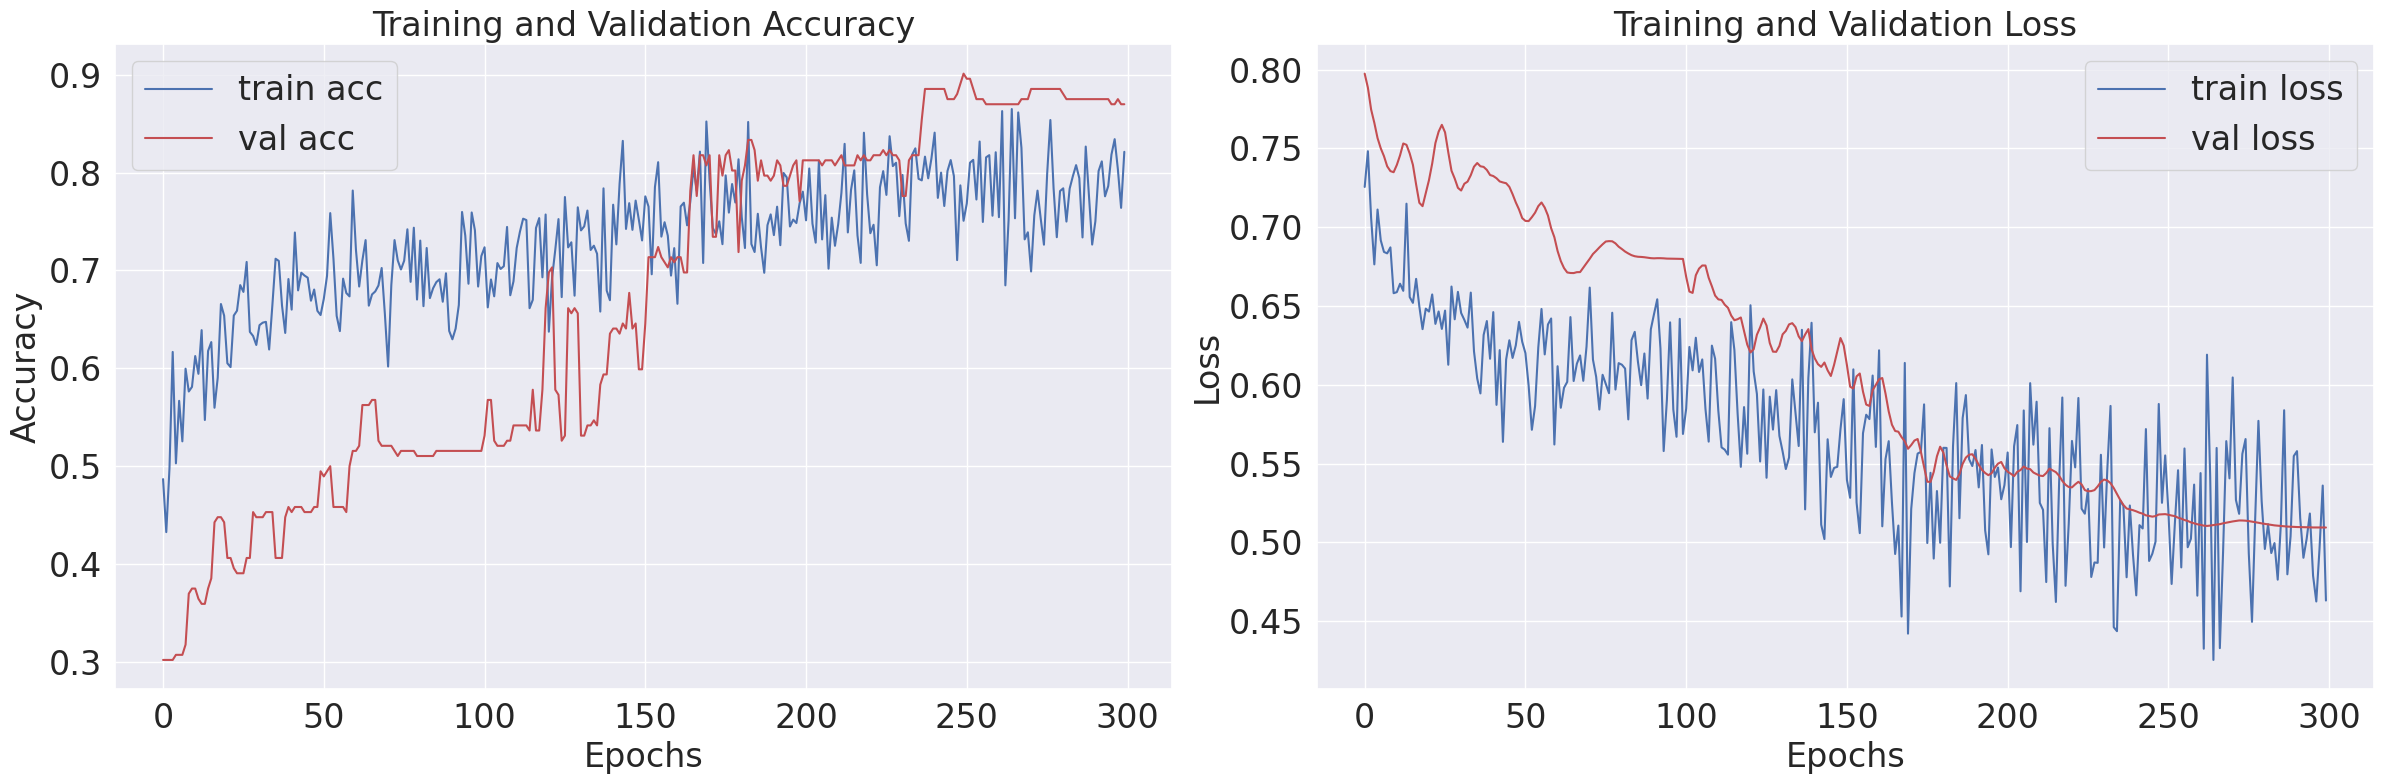

In [5]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 仮にepochsの数をトレーニングデータの長さから取得する
epochs = len(train_acc_list)  # train_acc_listの長さを使用

train_acc = []
train_loss = []
val_acc = []
val_loss = []

# 各リストをnumpy配列に変換し、リストに追加
for i in range(epochs):
    train_acc.append(train_acc_list[i].detach().cpu().numpy())
    train_loss.append(train_loss_list[i].detach().cpu().numpy())
    val_acc.append(val_acc_list[i].detach().cpu().numpy())
    val_loss.append(val_loss_list[i].detach().cpu().numpy())

# グラフ化
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.plot(range(epochs), train_acc, 'b', label='train acc')
ax1.plot(range(epochs), val_acc, 'r', label='val acc')
ax1.set_title('Training and Validation Accuracy',fontsize=24)
ax1.set_xlabel('Epochs',fontsize=24)
ax1.set_ylabel('Accuracy',fontsize=24)
ax1.legend(fontsize=24)
ax1.tick_params(labelsize=24)

ax2.plot(range(epochs), train_loss, 'b', label='train loss')
ax2.plot(range(epochs), val_loss, 'r', label='val loss')
ax2.set_title('Training and Validation Loss',fontsize=24)
ax2.tick_params(labelsize=24)
ax2.set_xlabel('Epochs',fontsize=24)
ax2.set_ylabel('Loss',fontsize=24)
ax2.legend(fontsize=24)
ax2.tick_params(labelsize=24)
plt.tight_layout()
plt.show()


In [11]:
model_save_path = '/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint3'
torch.save(model.state_dict(), model_save_path)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

def extract_logits(model, loader, device):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

# ロジットとターゲットを抽出
val_logits, val_targets = extract_logits(model, valid_loader, device)

# プラットスケーリングを使用してモデルをカリブレーション
calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

# 検証セットのロジットとターゲットを使って、ベースのcalibratorをフィッティング
calibrator.fit(val_logits, val_targets)
# 検証セットの確率を使ってフィッティング
calibrated_model.fit(val_logits, val_targets)

# カリブレーション後の確率を評価
calibrated_probs = calibrated_model.predict_proba(val_logits)[:, 1]

# パフォーマンス評価
roc_auc = roc_auc_score(val_targets, calibrated_probs)
print(f"Calibrated ROC AUC: {roc_auc:.4f}")

# 保存や他の用途で使用するためにモデルを更新
model.calibrator = calibrated_model

Calibrated ROC AUC: 0.9283


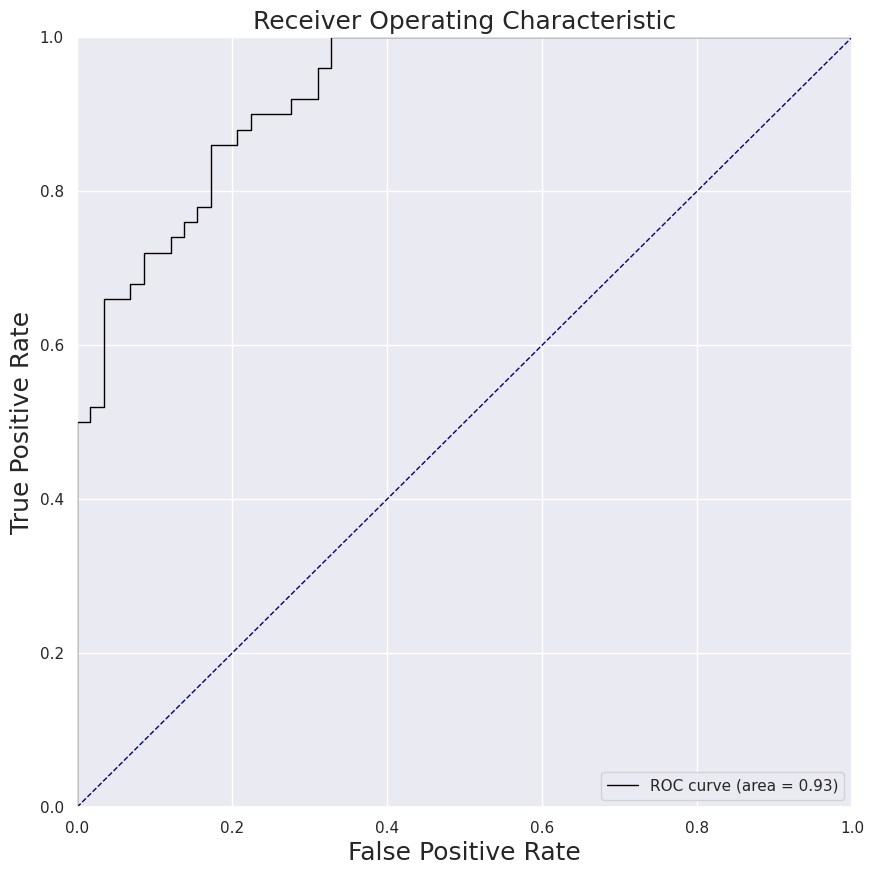

In [13]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, loader, device):
    # 真のラベルと予測確率を収集
    true_labels = []
    pred_probs = []

    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            # ソフトマックスを適用して確率を取得
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            pred_probs.extend(probabilities[:, 1].cpu().numpy())  # クラス1の確率を取得
            true_labels.extend(labels.cpu().numpy())

    # ROCカーブの計算
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # ROCカーブの描画
    plt.figure(figsize=(10, 10))
    lw = 1
    plt.plot(fpr, tpr, color='black',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 2], [0, 2], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver Operating Characteristic',fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# 使用例: 有効データローダーとデバイス情報を指定してROC曲線を描画
plot_roc_curve(model, valid_loader, device)


In [14]:
import pickle
# カリブレーターの保存
with open('/content/drive/MyDrive/calibrated_model3.pkl', 'wb') as f:
    pickle.dump(calibrated_model, f)

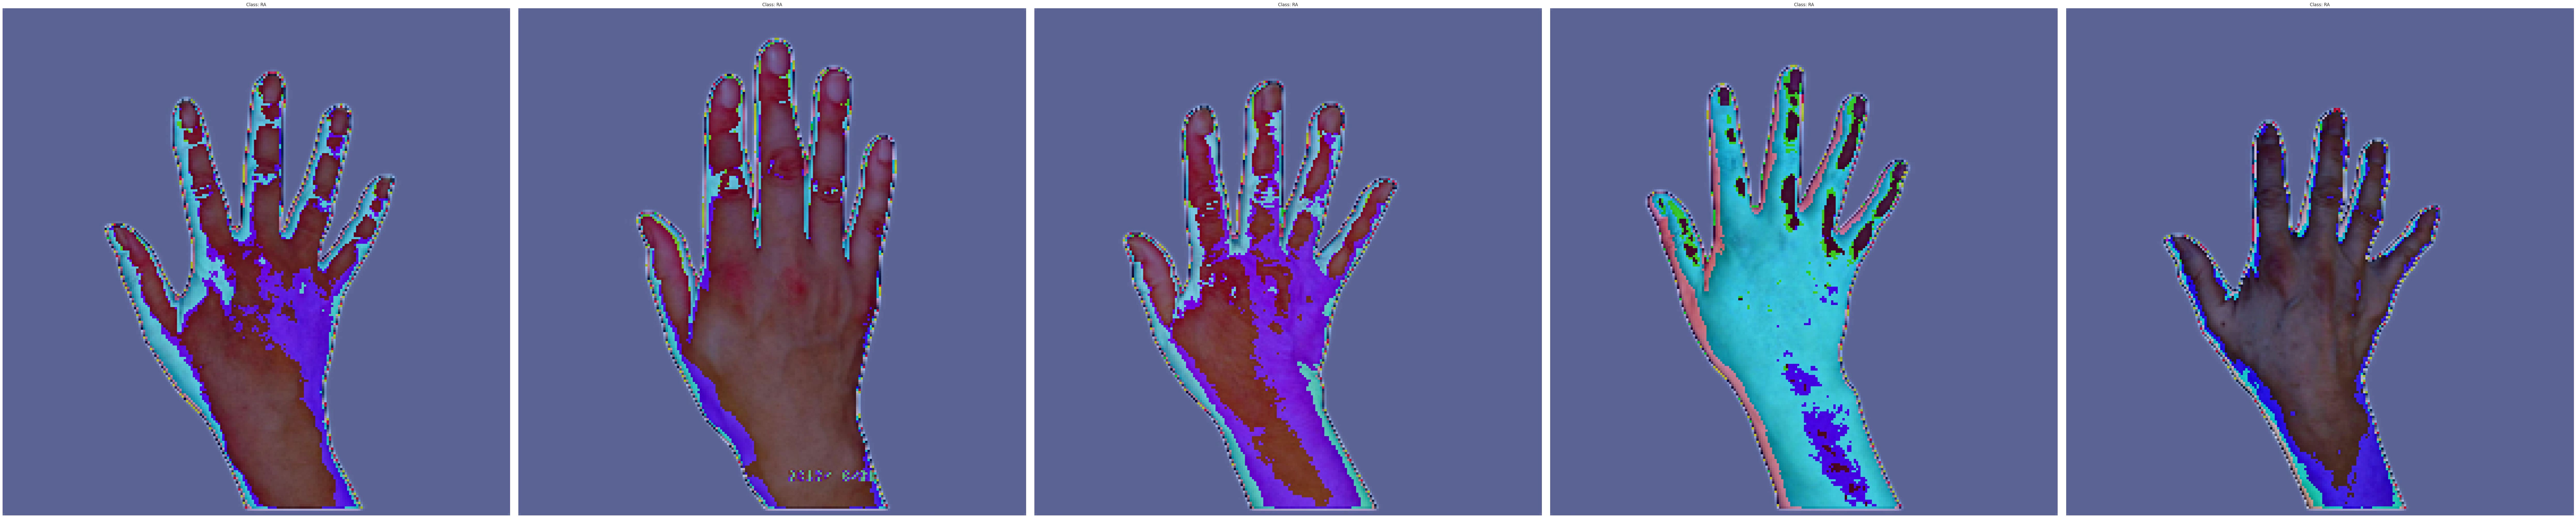

66688

In [15]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # Swin Transformerの最後のブロックを取得
        if hasattr(model, 'layers'):
            target_layer = model.layers[-1].blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        x = x.to(self.device)

        output = self.model(x)
        pred_class = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # Swin Transformerの特徴量マップの形状に合わせて処理
        feature_map = self.feature
        gradient_map = self.gradient

        # 重みの計算
        weights = gradient_map.mean(dim=(2, 3))  # Swinの場合、spatial dimensionsで平均を取る

        # CAMの計算
        batch_size = feature_map.shape[0]
        height = feature_map.shape[2]
        width = feature_map.shape[3]

        cam = torch.mul(feature_map, weights.view(batch_size, -1, 1, 1))
        cam = cam.sum(dim=1)  # チャネル方向に集約

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# 実行部分
grad_cam = GradCam(model, device)

images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

plt.figure(figsize=(100, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        heatmap = grad_cam(image.unsqueeze(0))
        overlayed = overlay_heatmap_to_image(image, heatmap)

        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch

# 1. 予測と確信度の取得
def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    image_paths = []  # 画像のパスまたは画像自体を保存

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            image_paths.extend(images.cpu())  # または元の画像パス

    return np.array(predictions), np.array(true_labels), np.array(confidences), image_paths

# 2. 混同行列の作成と可視化
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 3. 誤分類サンプルの分析
def analyze_misclassifications(true_labels, predictions, confidences, image_paths, class_names):
    # 誤分類のインデックスを取得
    misclassified_idx = np.where(predictions != true_labels)[0]

    # 確信度でソート
    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    # 上位の誤分類ケースを表示
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < len(sorted_idx):
            mis_idx = sorted_idx[idx]
            image = image_paths[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            ax.imshow(image.permute(1, 2, 0))
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# 4. 確信度分布の分析
def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(10, 6))

    # 正解と不正解の確信度を分離
    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メイン実行部分
def analyze_errors(model, val_loader, class_names, device):
    # 予測の取得
    predictions, true_labels, confidences, image_paths = get_predictions(model, val_loader, device)

    # 1. 全体の性能メトリクス
    print("Overall Accuracy:", np.mean(predictions == true_labels))

    # 2. 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 3. 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences,
                             image_paths, class_names)

    # 4. 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # 5. クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

<ipython-input-16-3c2aafc37d31>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_check

Overall Accuracy: 0.769


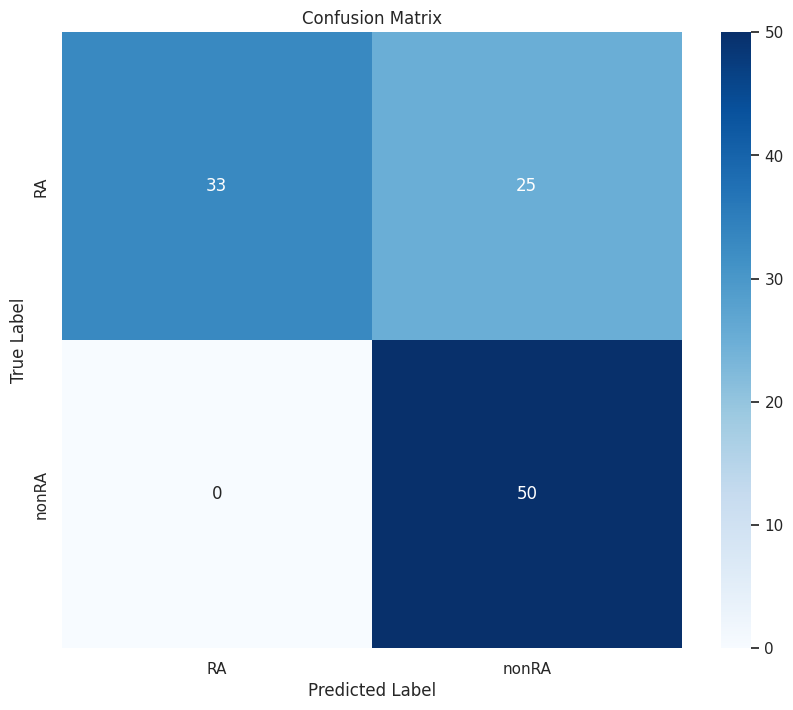

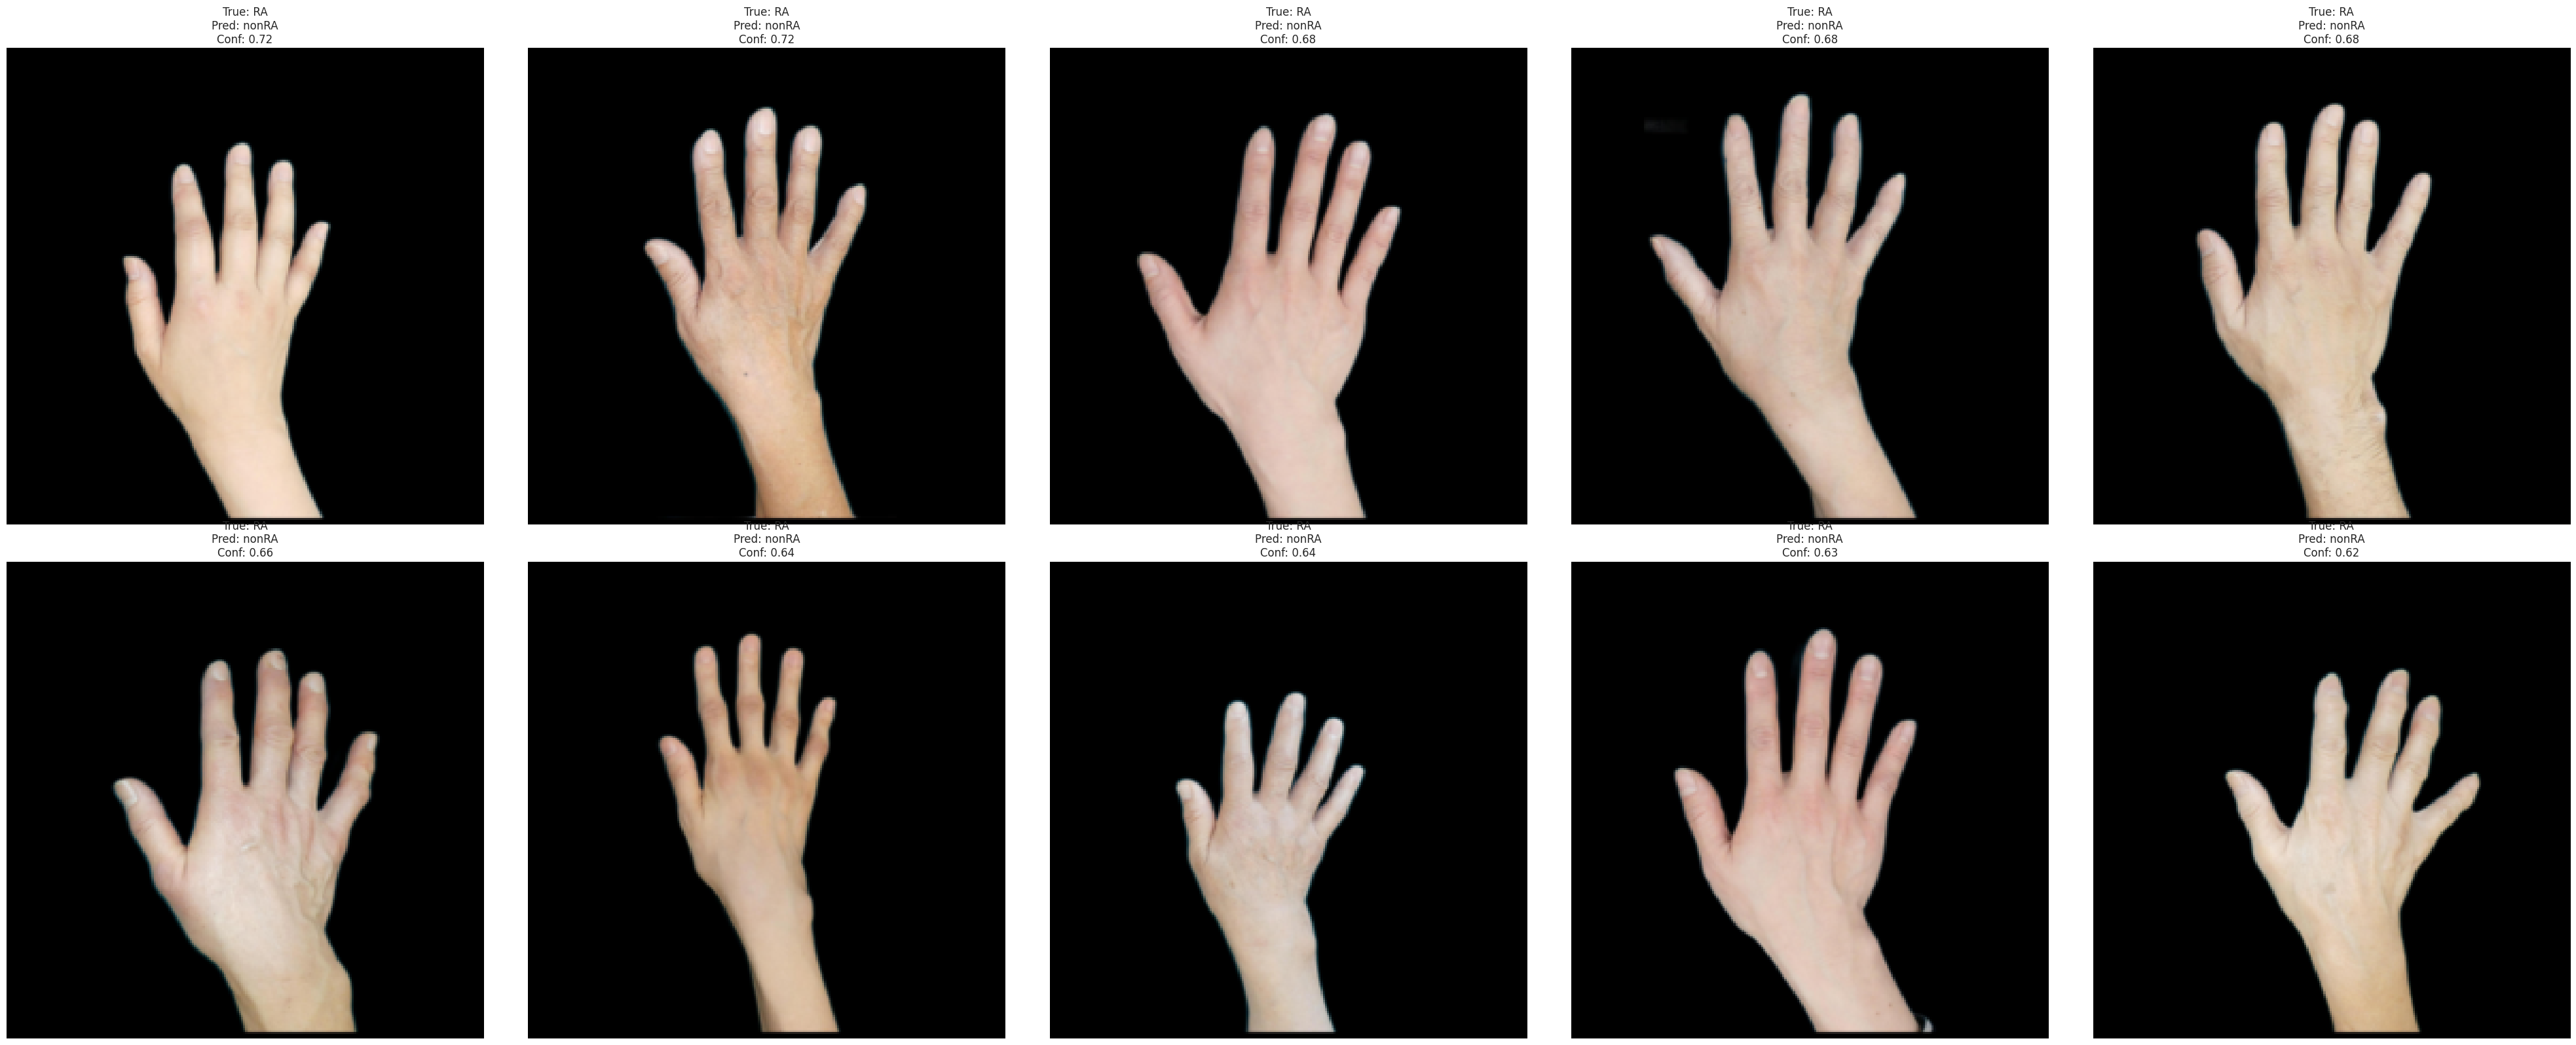

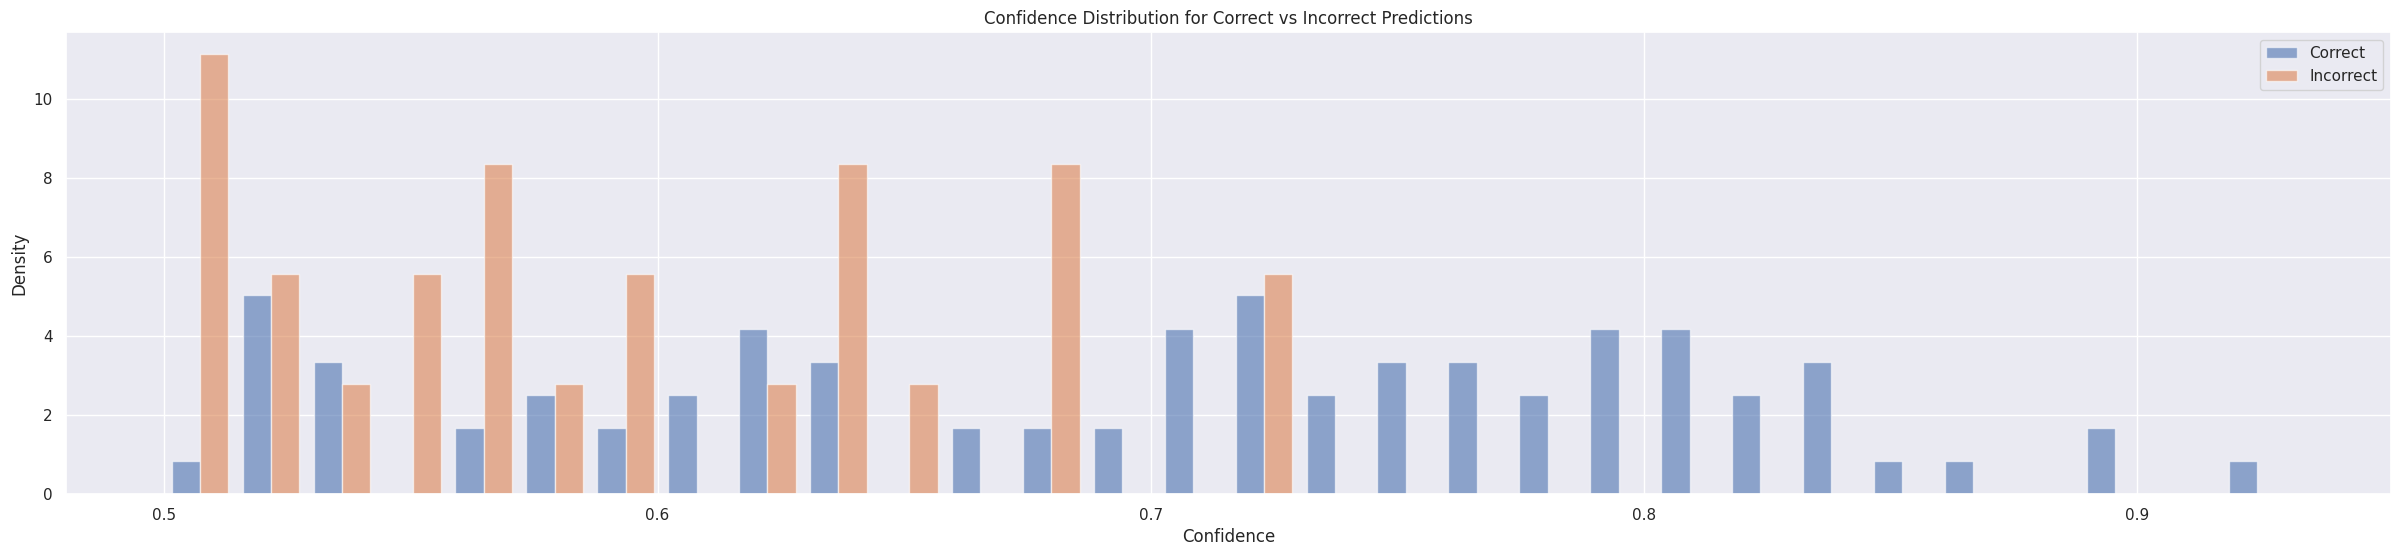


Class RA:
Accuracy: 0.569
Average confidence: 0.640
Samples: 58

Class nonRA:
Accuracy: 1.000
Average confidence: 0.717
Samples: 50


In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    images_list = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            images_list.extend(images.cpu())

    return np.array(predictions), np.array(true_labels), np.array(confidences), images_list

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names):
    misclassified_idx = np.where(predictions != true_labels)[0]

    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return

    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    n_samples = min(10, len(sorted_idx))
    fig, axes = plt.subplots(2, 5, figsize=(40, 16))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < n_samples:
            mis_idx = sorted_idx[idx]
            image = images_list[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            # 画像の正規化を元に戻す（必要に応じて調整）
            image = image.permute(1, 2, 0)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            image = torch.clamp(image, 0, 1)

            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(30, 6))

    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メインの実行コード
def main():
    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # クラス名の設定（あなたのデータセットに合わせて修正）
    class_names = ['RA', 'nonRA']  # あなたのクラス名に置き換えてください

    model = timm.create_model(
        'swin_base_patch4_window7_224.ms_in1k',
        pretrained=False,
        num_classes=2,
    )

    # モデルの読み込み（あなたの保存したモデルのパスに修正）
    model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint3'))
    model = model.to(device)

    # 予測の実行
    predictions, true_labels, confidences, images_list = get_predictions(model, val_loader, device)

    # 全体の性能メトリクス
    accuracy = np.mean(predictions == true_labels)
    print(f"Overall Accuracy: {accuracy:.3f}")

    # 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names)

    # 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

if __name__ == '__main__':
    val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)  # あなたの検証用DataLoaderを設定

    main()